<h1>Attempt1: Linear regression of relative frequency of words</h1>

As a first attempt, we tried to use linear regression to estimate the changing rate of relative frequency of each word and select those words with the highest rate of increasing relative frequency to represent trends. Specifically, we 
1. Cleaned the raw data, removed as many references as possible. 
2. Used CountVectorizer with a modified tokenizer to do preprocessing and counted frequencies of unigrams and bigrams. This is done for both abstracts and full texts. 
3. Normalized the frequency of each word to the length of each article as the relative frequency. 
4. Binned papers based on their years of publication and calculated the average relative frequency of each word for each year. 
5. Conducted a linear regression of average relative frequency of words as a function of time and selected words with highest positive slope. These words show increasing relative frequency over time and thus represent a trend.

For unigram, abstracts and full texts share 5 out of 10. For bigram, abstracts and full texts only share 2 out of 10. We selected 5 unigrams and 5 bigrams that have real meanings. These terms are either shared between abstracts and full texts or selected from abstract alone, because we think ngrams selected from the abstract are more representative. 

<h3> The words that represent trends include: 'bound', 'distribution', 'graph', 'matrix', 'method', 'machine learning', 'high dimensional', 'convex optimization', 'latent variable', and 'inference algorithm'</h3>

In [127]:
import os
import warnings
import logging
import pprint
import pickle
import sys
from datetime import datetime
from time import time

## Basic data processing and plotting libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Text pipeline and NLP packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords  
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
import string
import regex as re
import unicodedata

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim import corpora, models 
from gensim.models import LdaSeqModel, LdaModel, LdaMulticore, Phrases, CoherenceModel
from gensim import corpora, models
from gensim.corpora import Dictionary

# integration with sklearn
from gensim.sklearn_api import LdaTransformer, LdaSeqTransformer

# scikit LDA and model selection
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

# DTM
from gensim.models.wrappers import DtmModel

# from pyemd import emd  

# SciKit visualization
from sklearn.manifold import TSNE, MDS

from sklearn.linear_model import LinearRegression

# Global constants and helper functions

In [4]:
DATADIR      = "./data"           # raw data directory
DATAFILE     = "nips-papers.xlsx" # name of dataset
PKLFILE      = "nips-papers.pkl"  # name of pickled data -- already cleaned
PKLDIR       = "./pickle"         # store pickled objects
DATCLEAN     = "nips-tokenized.pkl" # preprocessed tokenized/lemmatized
NLTKDIR      = "./nltk-data"      # NLTK downloads
SAMPLE       = True               # use only a sample of the data
SAMPLE_FRAC  = 0.2                # fraction of data to sample
EXTRACT_REFS = True               # Extract references from text section
REMOVE_REFS  = True               # Remove reference section from text
USE_LEMMA    = True               # use lemmatization
# USE_STEM     = True               # stem words
RANDOM_SEED  = 999                # seed for scikit-learn and random, eg. LDA

# General settings
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True) # minimal

def is_interactive():
    """True if running script interactively."""
    return not hasattr(sys.modules['__main__'], '__file__')

def root_path():
    """Root of project for downloading stuff. The lemmatization requires
    a download of the wordnet lemma data - but its not too large."""
    return os.path.realpath(os.path.curdir) if is_interactive() else \
        os.path.dirname(__file__)

# download nltk libraries in project root (they are in .gitignore)
nltk.data.path = [os.path.join(root_path(), NLTKDIR)]

# logging
# logging.basicConfig(
#     level=logging.WARNING, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# pretty printing
pp = pprint.PrettyPrinter(indent=4)

## -------------------------------------------------------------------
### General helper functions

def get_nltk_prereqs():
    """Download NLTK prereqs in root NLTKDIR."""
    nltk.download(['wordnet', 'punkt', 'stopwords', 'averaged_perceptron_tagger'],
                  download_dir=os.path.join(root_path(), NLTKDIR))

def timeit(func):
    """Simple decorator to print execution time."""
    def timed(*args, **kw):
        t0 = time()
        res = func(*args, **kw)
        t1 = time() - t0

        print(f"{func.__name__} finished in ", end='')
        if t1 > 60:
            print(f"{t1 / 60.:0.2f} minutes")
        else:
            print(f"{t1:0.2f} seconds")
        return res

    return timed

def get_save_name(sections):
    """Return name of saved data composed of sections."""
    return '_'.join(sections) if isinstance(sections, list) else sections

def get_save_path(name):
    """Return filepath and whether it exists in the in pickle directory."""
    pklpath = os.path.join(root_path(), PKLDIR, name)
    return pklpath, os.path.exists(pklpath)

def pickle_load(filename="models.pkl"):
    """Load pickled objects, eg. models, datasets."""
    pklpath = os.path.join(root_path(), PKLDIR, filename)
    if os.path.exists(pklpath):
        with open(pklpath, "rb") as f:
            return pickle.load(f)
    return dict()

def pickle_save(obj, filename="models.pkl"):
    """OBJ should be a dictionary with all of the objects to pickle."""
    pklpath = os.path.join(root_path(), PKLDIR, filename)
    with open(pklpath, "wb") as f:
    	pickle.dump(obj, f)

def load_tokenized_data(filename=DATCLEAN):
    """Load preprocessed tokenized/lemmatized data."""
    dpath = os.path.join(root_path(), DATADIR, 'nips-tokenized.pkl')
    return pickle_load(dpath) if os.path.exists(dpath) else None

# Cleaning the raw data - removing and listififying references from the texts

In [5]:
"""
This module contains a wrapper class to store the NIPs data.
Configuration can be handled in hw2_config by setting global constants,
or in the class constructor.

If a clean pickled version of the data is available, it is loaded and 
none of the cleaning is done.

Otherwise, by default, when raw data is loaded it:
  - creates lists of references from the text of the articles (from the 
    References section), adding a new column "refs" to the data.
  - removes the Reference section from the text
  - takes a working sample of the data if requested

Useful methods:
  - load_data: loads data using the current settings
  - resample: resamples the raw dataset a given sample fraction
  - to_pickle: save the data to a pickle file
  - combined_sections: return series with sections combined

Note: when left with defaults, the final columns will be 
  ['id', 'year', 'title', 'abstract', 'text', 'refs']
and the shape (7241, 6).
"""

class NipsData:
    """Wrapper around NIPs dataset."""
    raw = None                  # raw data
    data = None                 # subset of data when sampling
    refs = None                 # extracted references
    do_refs = False             # true if should extract references
    do_remove_refs = False      # true if should remove refs from text
    has_refs = False            # data has a 'refs' column
    refs_removed = False        # reference section is removed from text
    root = None                 # project root
    data = None                 # data file
    datadir = None              # data directory
    is_sample = True            # use sample of total dataset
    sample_frac = None          # fraction of data to use in sample
    pklfile = None              # pickled version of cleaned data


    def __init__(self, **kw):
        """
        Manages NIPs data. If there is a pickled version available it is loaded
        without doing any cleaning.

        Default options (can be passed in constructor or changed in global config):
          - add column with list of references extracted from text
          - remove the references section from article text
          - use a sample of the raw data
        """
        self.pklfile = kw.pop('pklfile', PKLFILE)
        self.do_refs = kw.pop('add_refs', EXTRACT_REFS)
        self.do_remove_refs = kw.pop('remove_refs', REMOVE_REFS)
        self.root = kw.pop('root', root_path())
        self.datafile = kw.pop('datafile', DATAFILE)
        self.datadir = kw.pop('datadir', DATADIR)
        self.is_sample = kw.pop('sample', SAMPLE)
        self.sample_frac = kw.pop('sample_frac', SAMPLE_FRAC)
        self.datapath = kw.pop('datapath', self._data_path())
        

    def _data_path(self):
        """Return the datapath, pickled if possible."""
        ddir = os.path.join(self.root, self.datadir)
        pkl = os.path.join(ddir, self.pklfile) if self.pklfile is not None else None
        if pkl is not None and os.path.exists(pkl):
            self.has_refs = True
            self.refs_removed = True
            return pkl
        self.pklfile = None
        return os.path.join(ddir, self.datafile) if self.datafile is not None \
            else None


    def __str__(self):
        res = f"Data: {self.datapath}\n\
Loaded: {self.raw is not None}\n\
Get-Refs: {self.do_refs}\n\
Has-Refs: {self.has_refs}\n\
Remove-Refs: {self.do_remove_refs}\n\
Refs-Removed: {self.refs_removed}\n\
Sample: {self.is_sample}\n"
        if self.is_sample:
            res += f"Sample-Fraction: {self.sample_frac}"
        return res

    def __repr__(self):
        return self.__str__()


    def to_pickle(self, **kw):
        """Save dataset as a pickle. Optionally specify output as 'file=...'."""
        default = os.path.join(self.datadir, self.pklfile if self.pklfile is not None
                               else 'nips-papers.pkl')
        self.raw.to_pickle(kw.pop('file', default))


    def load_data(self, **kw):
        """
        Loads data, pickled file if available. The data location can be
        specified in class constructor or set manually. 

        If raw data is read, references are computed/removed once for the
        raw data which can then be repeatedly sampled from.
        
        Returns processed data.
        """
        if self.raw is None:
            if self.pklfile is not None: # pickled file already has refs removed
                self.raw = pd.read_pickle(self.datapath)

            else:
                self.raw = pd.read_excel(self.datapath)

                # add references column / remove references from text
                # only run once on the raw data, which can be sampled later
                self._update_references()
        
        # Use only a fraction of data for preliminary runs
        if self.is_sample:
            seed = kw.pop('seed', RANDOM_SEED)
            self.sample_frac = kw.pop('sample_frac', self.sample_frac)
            if self.sample_frac == 1:
                self.is_sample = False
            else:
                self.data =\
                    self.raw.sample(frac=self.sample_frac, random_state=seed)

        if not self.is_sample:
            self.data = self.raw.copy(deep=True)
            
        self.data.sort_index(inplace=True)
        return self.data


    def resample(self, fraction, **kwargs):
        """Resample raw data using FRACTION of total. Returns new sample."""
        self.sample_frac = fraction
        if self.sample_frac < 1:
            self.is_sample = True
        seed = kwargs.pop('seed', np.random.randint(0, 10000))
        kwargs = dict(seed = seed)
        self.load_data(**kwargs)
        return self.data
    

    def combined_sections(self, sections, data=None):
        """Return combined sections from data, eg. 'title' + 'abstract'."""
        if data is None:
            data = self.raw
        if not isinstance(sections, list):
            return data[sections]
        return data[sections].apply(lambda x: '\n\n'.join(x), axis=1)


    ## -------------------------------------------------------------------
    ### Managing References

    def _find_references(self):
        """
        Pulls out references from papers, returns a list of references indexed by
        paper ID. Only returns references from papers where a reference section was
        actually found. 

        Notes: 
          - some papers are truncated / missing references section. 
          - Also the references appear to be truncated in cases (eg. 6556).
          - the text is split by a reference regex that may match in multiple
            places, so the last element is the correct one. However, the entire
            list is returned here to enable later processing if desired (eg.
            removing the reference section).

        The formats that are parsed are:
        References: (sometimes capitalized, eg. 1)
        [1] or (1) or 1. ...
        [2] or (2) or 2. ...
        ...

        However, some are just formatted as 
        References:
        ...
        And these are ignored for now since they are hard to parse.

        There seem to be ~2500 texts w/o detected reference sections in the cleaned 
        version of the data posted on piazza.
        """
        self.refs = self.raw.text.str.split(
            r"\s+[Rr][Ee][Ff][Ee][Rr][Ee][Nn][Cc][Ee][Ss]\s+(?=[\[\(][0-9]{1,3}|[0-9]{1,3}[.]\s+)")
        mask = (self.refs.apply(len) > 1) # ignore texts with no detected references
        self.refs = self.refs[self.raw.text[mask].index]


    def _split_references(self, refs):
        """
        Split reference text into references where possible.

        They could be of forms: [1] ..., (1) ..., or 1. ...
        Others are ignored (hopefully).

        There are also assumed to only be upto 3 digits in a reference to avoid 
        possible complication with years.
        """
        return refs.str.split(
            r"(?:^|\A|\n)\s*(?:[\[\(][0-9]{1,3}[\]\)]|[0-9]{1,3}[.]\s+)\s*")\
                       .apply(lambda x: [i for i in x if len(i) > 0])


    def _add_reference_column(self):
        """Add references to data. Pass pre-computed 'refs' to avoid recomputation."""
        # Only use the last section
        self.raw["refs"] = self._split_references(self.refs.apply(lambda x: (x[-1:])[0]))
        self.has_refs = True


    def _remove_reference_section(self):
        """
        Remove the reference section from text. The text is split into possible 
        reference sections by `_find_references`, and the last section, presumably the
        actual reference section is removed.

        The split sections, minus the last one, are joined back together with 
        ' references '.
        """
        # a couple have random refs, but the last section should be right
        self.raw.text[self.refs.index] = \
            self.refs.apply(lambda x: ' references '.join(x[:-1]))
        self.refs_removed = True


    def _update_references(self):
        """
        Do the configured operations on the data related to references.
        Calls _add_reference_column and _remove_reference_section when 
        applicable.
        """
        if (self.do_remove_refs and not self.refs_removed) or\
           (self.do_refs and not self.has_refs):
            # find references if necessary and add refs column
            if not self.has_refs:
                self._find_references()
                self._add_reference_column()

            # remove references from text
            if self.do_remove_refs and not self.refs_removed:
                self._remove_reference_section()


<h3> Load data, sort based on year and calculate number of articles each year </h3>

In [6]:
## Load raw data
nips = NipsData()
nips_raw = nips.load_data(sample_frac=1)
nips

Data: /home/noah/class/cs82-advanced-ml/hw2/./data/nips-papers.pkl
Loaded: True
Get-Refs: True
Has-Refs: True
Remove-Refs: True
Refs-Removed: True
Sample: False

In [7]:
def data_info(data):
    """Print basic data info."""
    print(f"Columns: {data.columns}")
    print(f"Shape: {data.shape}")
data_info(nips_raw)
nips_raw.head()

Columns: Index(['id', 'year', 'title', 'abstract', 'text', 'refs'], dtype='object')
Shape: (7241, 6)


id  year                                              title  \
0   1  1987  Self-Organization of Associative Database and ...   
1   2  1987  The Capacity of the Kanerva Associative Memory...   
2   3  1987  Supervised Learning of Probability Distributio...   
3   4  1987              Constrained Differential Optimization   
4   5  1987  Towards an Organizing Principle for a Layered ...   

                                            abstract  \
0  An efficient method of self-organizing associa...   
1  The capacity of an associative memory is defin...   
2  We propose that the back propagation algorithm...   
3  Many optimization models of neural networks ne...   
4  An information-theoretic optimization principl...   

                                                text  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   
1  184\n\nTHE CAPACITY OF THE KANERVA ASSOCIATIVE...   
2  52\n\nSupervised Learning of Probability Distr...   
3  612\n\nConstrained Differential Optimization\n...   
4  485\n\nTOWARDS AN ORGANIZING PRINCIPLE FOR\nA ...   

                                                refs  
0  [Hopfield, J. J. and D. W. Tank, "Computing wi...  
1  [R.J. McEliece, E.C. Posner, E.R. Rodemich, an...  
2  [Werbos,P, "Beyond Regression: New Tools for P...  
3  [K. J. Arrow, L. Hurwicz, H. Uzawa, Studies in...  
4  [[2], [4], [6], [8], [10], [12]\n\nR. Linsker,...

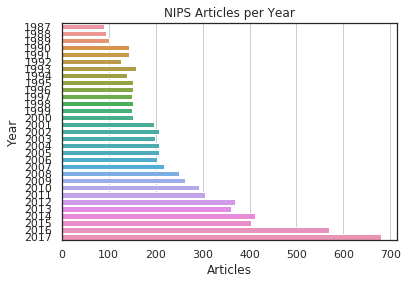

Extracted references from 4825 texts


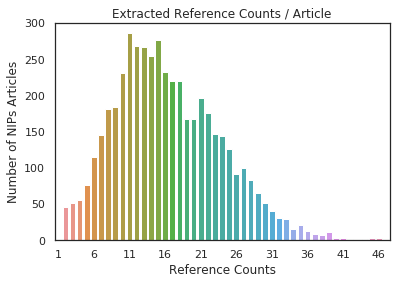

In [8]:
## Data exploration

# Papers over time: generally exponentially growing #papers/year
def data_papers_per_year(data):
    """Barplot of NIPs papers per year."""
    sns.countplot(y='year', data=data)
    plt.grid(axis='x')
    plt.title("NIPS Articles per Year")
    plt.xlabel("Articles")
    plt.ylabel("Year")
    plt.show()
    
# Papers w/ References
def data_refs_info(data):
    """Show info on extracted references from articles."""
    if "refs" in data:
        print(f"Extracted references from {data['refs'].count()} texts")
        refs = data['refs'].dropna().apply(len)
        sns.countplot(x=refs)
        plt.title("Extracted Reference Counts / Article")
        plt.ylabel("Number of NIPs Articles")
        plt.xlabel("Reference Counts")
        ticks = np.unique(refs)
        plt.xticks(ticks[::5], np.arange(1, max(refs))[ticks[::5]])
        plt.show()


# Word distributions
def data_word_distributions(data):
    """Rough distributions of word counts in titles, article, and texts."""
    sns.set(style="white", color_codes=True) # minimal
    fig, axs = plt.subplots(ncols=3, facecolor='w', edgecolor='k')
    
    for i, col in enumerate(["title", "abstract", "text"]):
        sns.distplot(data[col].str.split('\s*').map(len), ax=axs[i])
        axs[i].set_xlabel(col)
        axs[i].set_yticklabels([])

    fig.suptitle("Distributions of word counts in NIPs corpus")
    plt.show()

data_papers_per_year(nips_raw)
data_refs_info(nips_raw)

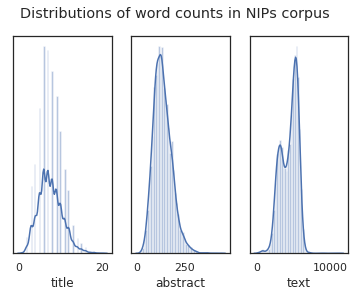

In [26]:
data_word_distributions(nips_raw)

<h3> Data preprocessing, lemmatization, stemming and tokenization.</h3> 
Note that the lemmatizer is extended for tokenization for gensim and scitkit models later on to incorport collocated ngrams.

In [9]:
"""
Tokenization:
  - lowercases
  - removes punctuation
  - cleans up unicode
  - breaks strings into words of at least 3 letters using RegexpTokenizer
  - lemmatizes words using WordNetLemmatizer if USE_LEMMA is True
  - stopwords are removed and later frequent and infrequent terms as well

Note: to use the nltk lemmatizer, there are a couple downloads required. The
wrapper function 'get_nltk_prereqs' will install them in the project root 
directory.
"""

def text_preprocess(doc, keep_joins=False):
    """
    Simple text prepocessing:
      - remove non-ascii and punctuation. Leaves [._-] unless keep_joins is False.
      - lowercase
    """
    nonascii = '[^\x00-\x7F]+'
    punkt = '[^.0-9A-Za-z_ \t\n\r\v\f-]'
    no_joins = '[^.0-9A-Za-z \t\n\r\v\f]'
    re_joins = re.compile(nonascii + "|" + punkt)
    re_nojoins = re.compile(nonascii + "|" + no_joins)

    return re.sub(re_joins if keep_joins else re_nojoins, ' ', doc).lower()


# Lemmatizer: can be used as a replacement tokenizer + lemmatizer in
# scikit-learn tokenizers
class LemmaTokenizer(object):
    """
    Regexp tokenizer (words >= 3) and lemmatizer. Can be passed to 
    scikit-learn vectorizers. By default, lemmatizes nouns, adjectives, 
    adverbs, and verbs. Leaves '-' to '_' in words if
    keep_joins is True.

    Optional arguments:
      - pos: one of, or list of, ['N', 'V', 'R', 'N'] for noun, verb, adverb, verb
        these determine which words get kept and lemmatized.
    """
    tags = {'J': wn.ADJ, 'V': wn.VERB, 'R': wn.ADV, 'N': wn.NOUN}
    
    def __init__(self, keep_joins=False, **kw):
        self.keep_joins = keep_joins
        self.wnl = WordNetLemmatizer()
        self.rt = RegexpTokenizer('(?ui)\\b[A-Za-z][A-Za-z0-9_-]*\\b')\
            if keep_joins else RegexpTokenizer('(?ui)\\b[A-Za-z][A-Za-z0-9]*\\b')
        self.pos = kw.pop('pos', False)
        if self.pos:
            self.tags = {i: self.tags[i] for i in self.pos}
        
    def __call__(self, doc):
        return list(filter(lambda x: len(x) > 2,
                           [self.wnl.lemmatize(w, pos=self.tags[t[0]])\
                            # .replace('-', '_')
                            for w, t in pos_tag(self.rt.tokenize(doc))
                            if t[0] in self.tags]))

    def __str__(self):
        return f"{type(self).__name__}(lemmatizer={self.wnl},\n\tpos={self.tags},\n\t\
tokenizer={self.rt})"
        
    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return f"{type(self).__name__}(lemmatizer={self.wnl},\n\tpos={self.tags},\n\t\
tokenizer={self.rt})"
        
    def __repr__(self):
        return self.__str__()

# Preprocess data and calculate total number of words for each abstract/article 

In [44]:
# Preprocessing of abstracts and full texts 
# Preprocessed texts are still stored in the dataframe 
## Convert to lowercase
nips_raw.loc[:,'abstract'] = nips_raw['abstract'].apply(lambda x: x.lower())
nips_raw.loc[:,'text'] = nips_raw['text'].apply(lambda x: x.lower())

## Make a copy and use the copy to make tokens and remove stop words 
## The copy (nips_processed) is only used for counting total number of words for each abstract/paper 
nips_processed = nips_raw.copy()
## Define stopwords 
stops = set(stopwords.words("english")) #stops
stops = stops.union(['I'])
## Initiate tokenizer 
##tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer('(?ui)\\b[a-z]{3,}\\w*\\b')
## tokenize and remove stopwords 
nips_processed.loc[:,'abstract'] = nips_processed['abstract'].apply(lambda x: tokenizer.tokenize(x)) 
nips_processed.loc[:,'abstract'] = nips_processed['abstract'].apply(lambda x: [word for word in x if word not in stops]) 
nips_processed.loc[:,'text'] = nips_processed['text'].apply(lambda x: tokenizer.tokenize(x)) 
nips_processed.loc[:,'text'] = nips_processed['text'].apply(lambda x: [word for word in x if word not in stops])

In [42]:
nips_processed.head()

id  year                                              title  \
0   1  1987  Self-Organization of Associative Database and ...   
1   2  1987  The Capacity of the Kanerva Associative Memory...   
2   3  1987  Supervised Learning of Probability Distributio...   
3   4  1987              Constrained Differential Optimization   
4   5  1987  Towards an Organizing Principle for a Layered ...   

                                            abstract  \
0  [efficient, method, self, organizing, associat...   
1  [capacity, associative, memory, defined, maxim...   
2  [propose, back, propagation, algorithm, superv...   
3  [many, optimization, models, neural, networks,...   
4  [information, theoretic, optimization, princip...   

                                                text  \
0  [self, organization, associative, database, ap...   
1  [capacity, kanerva, associative, memory, expon...   
2  [supervised, learning, probability, distributi...   
3  [constrained, differential, optimization, john...   
4  [towards, organizing, principle, layered, perc...   

                                                refs  
0  [Hopfield, J. J. and D. W. Tank, "Computing wi...  
1  [R.J. McEliece, E.C. Posner, E.R. Rodemich, an...  
2  [Werbos,P, "Beyond Regression: New Tools for P...  
3  [K. J. Arrow, L. Hurwicz, H. Uzawa, Studies in...  
4  [[2], [4], [6], [8], [10], [12]\n\nR. Linsker,...

In [43]:
## Compute the length of each abstract and paper after tokenization and removing stop words 
abstracts_length = nips_processed['abstract'].apply(lambda x: len(x))
print(abstracts_length.head())
papers_length = nips_processed['text'].apply(lambda x: len(x))
print(papers_length.head())

0     44
1     68
2     29
3    102
4     86
Name: abstract, dtype: int64
0    1627
1    1216
2     962
3    1906
4    2632
Name: text, dtype: int64


<h3> Count term frequencies of abstracts and full texts respectively </h3>

In [115]:
# Function to build tf (raw term count) features from the corpus 
# texts should be lower case corpora with special characters removed
def build_tf(texts, n_features, ngram):
    ## Only extract the top n_features features/words
    stops = set(stopwords.words("english")) 
    stops = stops.union(['I'])

    ## Corpus does not work here
    ## Need to supply a list of strings and each string corresponds to a paper 
    print("Extracting tf features...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                    decode_error='ignore',
                                    strip_accents='unicode',
                                    max_features=n_features,
                                    ngram_range = (ngram,ngram),
                                    stop_words = stops,
                                    tokenizer=LemmaTokenizer(),
                                    token_pattern=u'(?ui)\\b[a-z]{3,}\\w*\\b')
                                    
    t0 = time()
    tf = tf_vectorizer.fit_transform(texts)
    print("done in %0.3fs." % (time() - t0))
    print()

    print("\nThe shape of our count vector matrix: ",tf.shape)
    print(tf_vectorizer.get_feature_names()[:30])
    print("=======================")

    tf_array = tf.toarray()
    return [tf_array, tf_vectorizer.get_feature_names()]

In [116]:
# Build tf (raw term count) features from the corpus 
n_features = 1000

## nips_raw should be reused here; 
## tokenization and stop words removal is done using countVectorizer 
abstract_tf_n1 = build_tf(nips_raw['abstract'], n_features=n_features, ngram=1)
abstract_tf_n2 = build_tf(nips_raw['abstract'], n_features=n_features, ngram=2)
paper_tf_n1 = build_tf(nips_raw['text'], n_features=n_features, ngram=1)
paper_tf_n2 = build_tf(nips_raw['text'], n_features=n_features, ngram=2)

Extracting tf features...
done in 4.553s.


The shape of our count vector matrix:  (7241, 1000)
['ability', 'able', 'according', 'account', 'accuracy', 'accurate', 'accurately', 'achieve', 'achieved', 'achieves', 'achieving', 'across', 'action', 'activation', 'active', 'activity', 'adaptation', 'adaptive', 'addition', 'additional', 'additive', 'address', 'advantage', 'adversarial', 'agent', 'aim', 'algorithm', 'alignment', 'allow', 'allowing']
Extracting tf features...
done in 6.349s.


The shape of our count vector matrix:  (7241, 1000)
['able learn', 'achieves state', 'across different', 'action potential', 'action space', 'activation function', 'active learning', 'actor critic', 'address issue', 'address problem', 'adversarial network', 'algorithm achieves', 'algorithm allows', 'algorithm also', 'algorithm applied', 'algorithm based', 'algorithm called', 'algorithm estimate', 'algorithm find', 'algorithm ha', 'algorithm including', 'algorithm learn', 'algorithm learning', 'algorithm

<h3> Calculate average relative frequency of words per year </h3>

In [117]:
# Function to compute text length normalized relative frequency of words for each year (per 1000 words)

def relative_frequency_per_year(tf_array, num_papers_per_year, texts_length, years = (1987,2018)):
    ## Iteration of texts and years
    count,n = 0,0
    ## Initiate an empty matrix (year by words)
    tf_norm = np.zeros([num_papers_per_year.shape[0],tf_array.shape[1]])

    ## Iterate over each year and 
    for i in list(range(years[0],years[1])):
        ## Total number of papers for ith year 
        num_papers = num_papers_per_year[i]
        print(f'Current year: {i}')
        print(f'Index of paper to start: {count}')
        print(f'Number of papers in this year: {num_papers}')
        ## subset word tokens from papers for ith year
        tf_tmp = tf_array[count:(count+num_papers),:]
        ## For each article Compute relative frequency of each word
        ## Normalized by length of each article and scaled by 1000
        tf_tmp = tf_tmp / texts_length[count:(count+num_papers),np.newaxis] * 1000
        ## Take the mean of relative frequency of each word across all papers of ith year 
        tf_norm[n,:] = tf_tmp.mean(axis=0)
    
        count = count + num_papers
        n += 1
        print(f'Index of paper to finish: {count}')
        print("=========")
        
    return tf_norm
    


In [118]:
## text length normalized relative frequency of words for single word of abstract
abstract_n1_tf_norm = relative_frequency_per_year(abstract_tf_n1[0], num_papers_per_year, abstracts_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

In [119]:
## text length normalized relative frequency of words for double words of abstract
abstract_n2_tf_norm = relative_frequency_per_year(abstract_tf_n2[0], num_papers_per_year, abstracts_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

In [120]:
## text length normalized relative frequency of words for single word of paper
paper_n1_tf_norm = relative_frequency_per_year(paper_tf_n1[0], num_papers_per_year, papers_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

In [121]:
## text length normalized relative frequency of words for double word of paper
paper_n2_tf_norm = relative_frequency_per_year(paper_tf_n2[0], num_papers_per_year, papers_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

<h3> Linear regression to calculate the rate of relative frequency change </h3>

In [122]:
# Conduct a linear regression for relative frequency of each word as a function of time 
# Store word the R2 and slope of the resulting linear model

def tf_linear_regression(tf_norm, words):
    coef = []
    rsquare = []
    lm = LinearRegression()
    
    ## Iterate over each word and do a linear regression as a function of time
    for i in range(tf_norm.shape[1]):
        x = np.array(list(range(tf_norm.shape[0]))).reshape(-1,1)
        y = tf_norm[:,i].reshape(-1,1)
        lm.fit(x,y)
        rsquare.append(lm.score(x,y))
        coef.append(float(lm.coef_))
    
    ## Make a df out of words, slope and R2 of the linear model for each word
    tmp = np.array([words, coef, rsquare])
    tmp = tmp.T
    term_freq = pd.DataFrame(tmp)
    term_freq.columns = ["word", "coef", "R2"]
    
    ## Adjust data type
    term_freq.coef = term_freq.coef.astype(float)
    term_freq.R2 = term_freq.R2.astype(float)
    
    return (term_freq)
    

In [123]:
abstract_n1_term_freq = tf_linear_regression(tf_norm = abstract_n1_tf_norm, words = abstract_tf_n1[1])
abstract_n2_term_freq = tf_linear_regression(tf_norm = abstract_n2_tf_norm, words = abstract_tf_n2[1])
paper_n1_term_freq = tf_linear_regression(tf_norm = paper_n1_tf_norm, words = paper_tf_n1[1])
paper_n2_term_freq = tf_linear_regression(tf_norm = paper_n2_tf_norm, words = paper_tf_n2[1])

<h3> Select words with the highest rate of increasing relative frequency to represent trends </h3>

In [187]:
# Function to select words with highest increasing rate of frequency to represent trends

def trend_words(term_freq):
    ## Sort the df by slope and only keep words with R2 > 0.6
    ## Print the first 10 words, which correspond to words with increasing relative frequency over time 
    term_freq2 = term_freq.sort_values(by= ["coef"], ascending=False)
    term_freq2 = term_freq2.loc[term_freq2["R2"] > 0.6,]
    trend_terms = term_freq2.word[:10]
    return(trend_terms)

<h4> Unigram trends detected from abstracts </h4>

In [188]:
## Abstract with single word 
abstract_n1_trend_terms = trend_words(abstract_n1_term_freq)
abstract_n1_trend_terms

552          method
813            show
694         problem
450       inference
94            bound
707         propose
257    distribution
403           graph
537          matrix
808         setting
Name: word, dtype: object

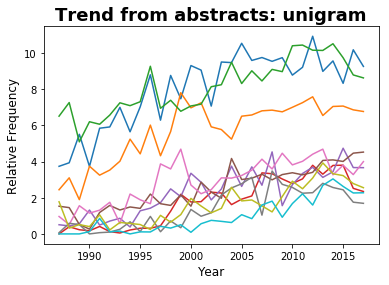

In [219]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n1_tf_norm[:,abstract_n1_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from abstracts: unigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h4> Bigram trends detected from abstracts </h4>

In [190]:
## Abstract with double words
abstract_n2_trend_terms = trend_words(abstract_n2_term_freq)
abstract_n2_trend_terms

879              state art
477       machine learning
348       high dimensional
781             real world
671          paper propose
155    convex optimization
757          propose novel
421        latent variable
907         synthetic real
376    inference algorithm
Name: word, dtype: object

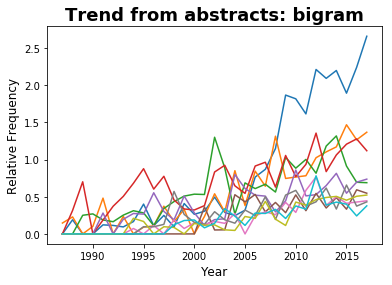

In [218]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n2_tf_norm[:,abstract_n2_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from abstracts: bigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h4> Unigram trends detected from full texts </h4>

In [193]:
## Full text with single word 
paper_n1_trend_terms = trend_words(paper_n1_term_freq)
paper_n1_trend_terms

25        algorithm
509             log
261    distribution
544          method
532          matrix
91            bound
776          sample
513            loss
912         theorem
397           graph
Name: word, dtype: object

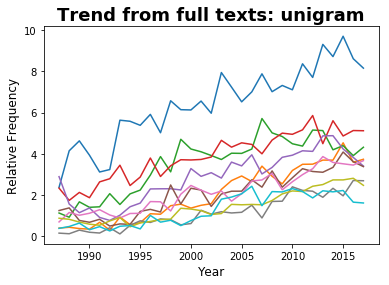

In [222]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             paper_n1_tf_norm[:,paper_n1_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from full texts: unigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h4> Bigram trends detected from full texts </h4>

In [194]:
## Full text with double words
paper_n2_trend_terms = trend_words(paper_n2_term_freq)
paper_n2_trend_terms

461                   log log
471               lower bound
466             loss function
635      optimization problem
848                 state art
470                  low rank
874    supplementary material
954               upper bound
472          machine learning
331           graphical model
Name: word, dtype: object

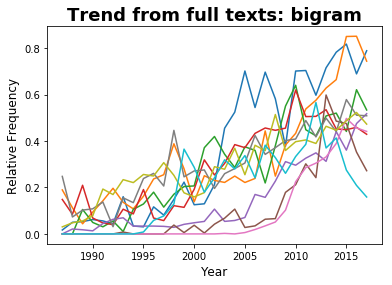

In [223]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             paper_n2_tf_norm[:,paper_n2_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from full texts: bigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h3> Shared trends between abstracts and full texts </h3>

In [139]:
## Shared single word between abstract and paper
np.intersect1d(abstract_n1_trend_terms, paper_n1_trend_terms)

array(['bound', 'distribution', 'graph', 'matrix', 'method'], dtype=object)

In [138]:
## Shared double words between abstract and paper
np.intersect1d(abstract_n2_trend_terms, paper_n2_trend_terms)

array(['machine learning', 'state art'], dtype=object)

<h3> Integrated results from unigrams and bigrams </h3>

<h4>Criteria</h4>
1. Select unigrams that are shared between abstracts and texts. This should remove words that are common in the abstract, like "show" and "propose". 
<br></br> 
2. Select bigrams mainly from abstracts, because the frequency of bigrams in full texts are very low, which reduces signals. Remove bigrams that collocate together, but have no special meanings. 
<br></br> 
3. Combine curated unigrams and bigrams. 
<br></br>

['bound', 'distribution', 'graph', 'matrix', 'method']


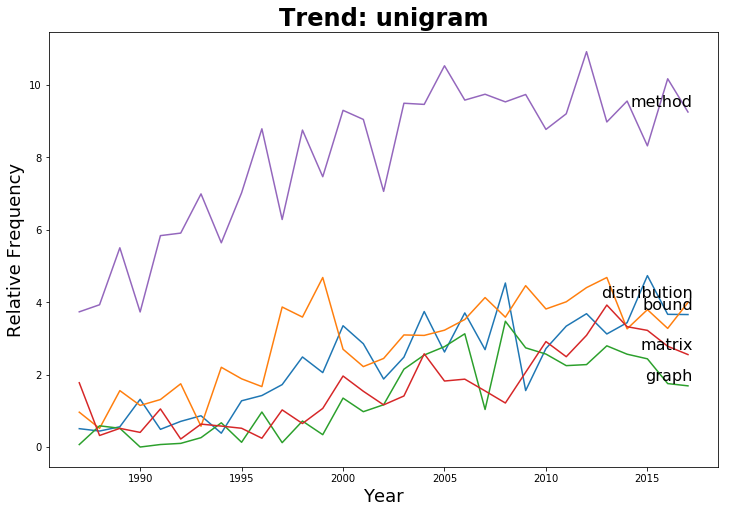

In [229]:
final_trend_unigram = ['bound', 'distribution', 'graph', 'matrix', 'method']
final_trend_unigram_index = [94, 257, 403, 537, 552]
print(final_trend_unigram)

x = np.array(list(range(1987,2018)))
y = abstract_n1_tf_norm[:,final_trend_unigram_index]

plt.figure(figsize=(12,8))
for i in list(range(5)):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n1_tf_norm[:,final_trend_unigram_index[i]].reshape(-1,1))
    plt.annotate(final_trend_unigram[i],
                     xy=(2017, abstract_n1_tf_norm[30,final_trend_unigram_index[i]]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                fontsize=16)

plt.title('Trend: unigram', fontsize=24, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Relative Frequency', fontsize=18)
plt.show()

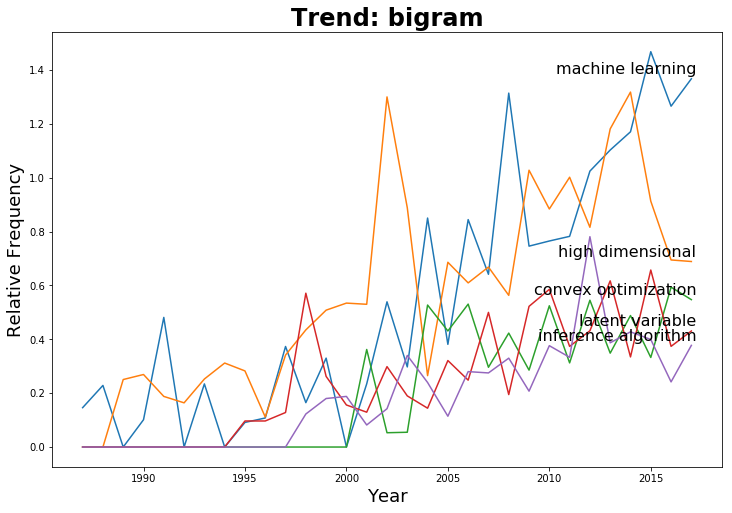

In [233]:
final_trend_bigram = ['machine learning', 'high dimensional', 'convex optimization', 
                      'latent variable', 'inference algorithm']
final_trend_bigram_index = [477, 348, 155, 421, 376]

x = np.array(list(range(1987,2018)))
y = abstract_n2_tf_norm[:,final_trend_bigram_index]

plt.figure(figsize=(12,8))
for i in list(range(5)):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n2_tf_norm[:,final_trend_bigram_index[i]].reshape(-1,1))
    plt.annotate(final_trend_bigram[i],
                     xy=(2017, abstract_n2_tf_norm[30,final_trend_bigram_index[i]]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                fontsize=16)

plt.title('Trend: bigram', fontsize=24, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Relative Frequency', fontsize=18)
plt.show()

# Attempt 2: collocalization
1. At first collocalizatio of bigrams and trigrams was attempted as an indicator of which topics might be common by year.
2. This was done using NLTK, but after experimenting with gensim's Phase, that seems to be the better option

In [10]:
"""
Find statistically collocated N-grams, eg. 'neural network'.
"""
# used to clean text prior to finding collocated ngrams
class NgramPreTokenizer(LemmaTokenizer):
    """
    Like NgramLemmaTokenizer but also does preprocessing:
      - converts to lowercase
      - removes unicode / punctuation
      - removes english stopwords
    """
    def __init__(self, **kw):
        super().__init__(**kw)
        self.tbl = dict.fromkeys( # translation table to remove unicode/punct
            i for i in range(sys.maxunicode)
            if unicodedata.category(chr(i)).startswith('P'))
        self.sw = stopwords.words('english')
        
    def __call__(self, doc):
        return list(filter(lambda x: len(x) > 2,
                           [self.wnl.lemmatize(w.lower().translate(self.tbl),
                                               pos=self.tags[t[0]])
                            for w,t in pos_tag(self.rt.tokenize(doc))
                            if t[0] in self.tags and w not in self.sw]))


def collocated_ngrams(data, num=100, kind='bigram', **kw):
    """
    Find NUM best bi/trigrams using wordnet's collocator. 'best' is determined
    by wordnets likelihood metric. KIND can be 'bigram' or 'trigram'.

    Returns list of tuples of ngrams.
    """
    if kind not in ['bigram', 'trigram']:
        raise ValueError("kind must be 'bigram' or 'trigram'")

    # the collocators don't seem to care if stopwords were previously removed
    stopset = set(stopwords.words('english'))
    npt = NgramPreTokenizer(**kw)
    tokens = data.map(npt)                          # tokenize the data

    cf = BigramCollocationFinder if kind is 'bigram' else TrigramCollocationFinder
    cf = cf.from_documents(tokens)
    cf.apply_word_filter(lambda w: w in stopset)         # remove grams w/ stopwords
    measure = BigramAssocMeasures if kind is 'bigram' else TrigramAssocMeasures
    grams = cf.nbest(measure.likelihood_ratio, num) # find the best
    
    return grams


# This can take quite a while running on the entire dataset, especially
# for trigrams. It uses NLTK for the collocations, doesn't seem to be multi-threaded
# like the scikit-learn functions.
@timeit
def compute_collocated_ngrams(data, num=10, ngram='bigram'):
    """Compute top NUM collocated n-grams for title, abstract, and text sections.
    N-grams can be 'bigrams' or 'trigrams'. Returns a dataframe of results."""
    return pd.DataFrame({
        "title": collocated_ngrams(data.title, num, ngram),
        "abstract": collocated_ngrams(data.abstract, num, ngram),
        "text": collocated_ngrams(data.text, num, ngram)
    })


def compute_all_collocations(nips, objs=None):
    """Compute all the collocated data that isn't pickled and store it."""
    df = nips.load_data()
    if objs is None:
        print("Loading collocs pickle")
        objs = pickle_load('collocs.pkl') or dict()

    if objs.get("all_bgs") is None: # these both take a while
        print("Computing collocated bigrams on entire dataset...")
        objs["all_bgs"] =\
            compute_collocated_ngrams(nips.raw, 500, 'bigram')
        pickle_save(objs, 'collocs.pkl')
    if objs.get("all_tgs") is None:
        print("Computing collocated trigrams on entire dataset...")
        objs["all_tgs"] =\
            compute_collocated_ngrams(nips.raw, 500, 'trigram')
        pickle_save(objs, 'collocs.pkl')
    if objs.get("bgs_by_yr") is None: # top 10 / year
        print("Computing collocated bigrams/year...")
        objs["bgs_by_yr"] =\
            nips.raw.groupby('year')\
                    .apply(compute_collocated_ngrams)\
                    .reset_index(drop=1)
        pickle_save(objs, 'collocs.pkl')
    if objs.get("tgs_by_yr") is None: # top 10 / year
        print("Computing collocated trigrams/year...")
        objs["tgs_by_yr"] =\
            nips.raw.groupby('year')\
                    .apply(lambda x: compute_collocated_ngrams(x, ngram='trigram'))\
                    .reset_index(drop=1)

    if objs.get('bgs') is None: # union of common bgs / year
        objs['bgs'] =\
            list(filter(lambda t: '' not in t,
                        np.unique(objs['bgs_by_yr'].unstack())))
        
    if objs.get('tgs') is None: # union of common tris / year
        objs['tgs'] =\
            list(filter(lambda t: '' not in t,
                        np.unique(objs['tgs_by_yr'].unstack())))
        
    assert len(objs) > 0
    print("Saving collocs pickle")
    pickle_save(objs, 'collocs.pkl')
    return objs


# Overlap between bigrams from different sections
# Highest overlap b/w text/abstract and abstract/title
def print_collocated_ngrams(df):
    """Print info about commonality b/w common n-grams in different document 
    sections."""
    tmp = df.apply(set)
    ngram = f"{len(df.iloc[0, 1])}-gram"
    print()
    print(f"Overlap in {ngram}s b/w doc sections:")
    print("  - title/text:\t\t", len(tmp.title & tmp.text))
    print("  - title/abstact:\t", len(tmp.title & tmp.abstract))
    print("  - text/abstract:\t", len(tmp.text & tmp.abstract))
    print("  - title/text/abstact:\t", len(tmp.title & tmp.abstract & tmp.text))
    print()
    print(df.head(5))


# Examining the collocated ngrams

In [11]:
# Load pickled objects: this holds objects that take a long time to compute
cs = pickle_load('collocs.pkl') or dict()

## -------------------------------------------------------------------
### Collocated ngrams
# Note: this takes a long time to run, it can computed from a different
# shell with 'make all-data'
compute_all_collocations(nips, cs)
bgs, all_bgs, bgs_by_year = cs.get('bgs'), cs.get("all_bgs"), cs.get('bgs_by_yr')
tgs, all_tgs, tgs_by_year = cs.get('tgs'), cs.get('all_tgs'), cs.get('tgs_by_yr')

Saving collocs pickle


In [12]:
# collocated ngrams using entire dataset: highest overlap b/w text and abstracts
# this is badly skewed towards recent years
print_collocated_ngrams(all_bgs)
print_collocated_ngrams(all_tgs)


Overlap in 2-grams b/w doc sections:
  - title/text:		 146
  - title/abstact:	 210
  - text/abstract:	 286
  - title/text/abstact:	 142

                       title                abstract  \
0          (neural, network)       (neural, network)   
1        (gaussian, process)          (monte, carlo)   
2  (reinforcement, learning)  (experimental, result)   
3             (monte, carlo)     (gradient, descent)   
4          (support, vector)     (gaussian, process)   

                        text  
0          (neural, network)  
1             (upper, bound)  
2                 (log, log)  
3  (supplementary, material)  
4               (low, bound)  

Overlap in 3-grams b/w doc sections:
  - title/text:		 132
  - title/abstact:	 110
  - text/abstract:	 199
  - title/text/abstact:	 84

                              title                          abstract  \
0      (recurrent, neural, network)      (recurrent, neural, network)   
1  (convolutional, neural, network)  (convolutional, neu

In [11]:
# Nearly every trigrams contains "neural", they are all related to neural networks
pd.DataFrame(np.mean(all_tgs.applymap(lambda x: "neural" in x)), columns=["%neural"])

%neural
title        0.69
abstract     1.00
text         1.00

In [12]:
# Bigrams are much more variable
pd.DataFrame(np.mean(all_bgs.applymap(lambda x: "neural" in x)), columns=["%neural"])

%neural
title       0.016
abstract    0.018
text        0.020

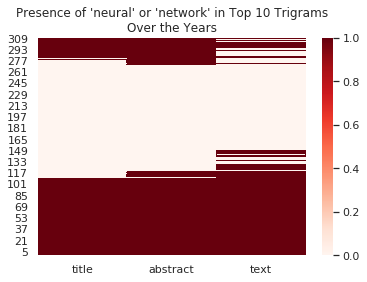

In [13]:
# However, using top ngrams / year shows different trends
# There is a big gap in neural network trigram popularity from late 1999-2014
nnet = tgs_by_year.groupby(tgs_by_year.index)\
                   .agg(lambda c: len([elem for elem in c
                  if any([i in elem for i in ['neural', 'network']])]))
sns.heatmap(nnet.sort_index(ascending=False), cmap='Reds')
plt.title("Presence of 'neural' or 'network' in Top 10 Trigrams\nOver the Years")
plt.show()

In [14]:
# pairs common to all sections
cbgs_intersect = set(all_bgs.text) & set(all_bgs.abstract) & set(all_bgs.title)
ctgs_intersect = set(all_tgs.text) & set(all_tgs.abstract) & set(all_tgs.title)

print("Bigrams common to all sections: ", len(cbgs_intersect))
pp.pprint(list(cbgs_intersect)[:10])
print("Trigrams common to all sections: ", len(ctgs_intersect))
pp.pprint(list(ctgs_intersect)[:10])

# The models use union of all sections from calculations / years
# Hopefully, this allows to see declining topics as well by reducing the
# skew
print("Union of common bigrams from all years: ", len(bgs))
print("Union of common trigrams from all years: ", len(tgs))

Bigrams common to all sections:  142
[   ('probability', 'distribution'),
    ('object', 'detection'),
    ('pattern', 'recognition'),
    ('multiarmed', 'bandit'),
    ('linear', 'program'),
    ('least', 'square'),
    ('positive', 'semidefinite'),
    ('inner', 'product'),
    ('value', 'function'),
    ('monte', 'carlo')]
Trigrams common to all sections:  84
[   ('neural', 'network', 'case'),
    ('neural', 'network', 'structure'),
    ('power', 'neural', 'network'),
    ('largescale', 'neural', 'network'),
    ('neural', 'network', 'implementation'),
    ('attractor', 'neural', 'network'),
    ('performance', 'neural', 'network'),
    ('structure', 'neural', 'network'),
    ('neural', 'network', 'visual'),
    ('cmac', 'neural', 'network')]
Union of common bigrams from all years:  249
Union of common trigrams from all years:  530


A new type of of tokenizer extending the lemmatizer was defined to incorporate the commonly occuring bi/trigrams in scikit-learn's vectorizers.

In [13]:
# Note: this approach was basically abandonded when I found out that
# gensim Phrases essentially does the same thing.
class NgramLemmaTokenizer(LemmaTokenizer):
    """
    Works like the LemmaTokenizer, but replaces collocated ngrams 
    with joined versions, eg. 'neural network' => 'neural_network'.
    
    This attempts to address the BOW assumption that word locations are
    independent.
    """
    def __init__(self, **kw):
        super().__init__(**kw)
        self.ngrams = kw.pop('ngrams', None)
        
    def __call__(self, doc):
        res = super().__call__(doc)
        return self.append_ngrams(res, self.ngrams) if self.ngrams is not None\
            else res

    @staticmethod
    def append_ngrams(lst, ngrams):
        """
        Append ngrams to lists with their joined forms, eg. 
        ['neural', 'neural', 'network'] => ['neural', 'neural_network'].
        Note: leaves unigrams in place so they can later be removed by 
        frequency trimming.
        """
        n = len(ngrams[0]) - 1
        for i in range(n, len(lst)):
            if tuple(lst[(i-n):(i+1)]) in ngrams:
                lst.append('_'.join(lst[(i-n):(i+1)]))
        return lst

    @staticmethod
    def replace_ngrams(lst, ngrams):
        """
        Replace ngrams with their joined forms, eg. 
        ['neural', 'neural', 'network'] => ['neural', 'neural_network'].
        """
        n = len(ngrams[0]) - 1
        res = lst[:(n-1)]
        skips = 0
        for i in range(n, len(lst)):
            if skips > 0:
                skips -= 1
                continue
            if tuple(lst[(i-n):(i+1)]) in ngrams:
                res.append('_'.join(lst[(i-n):(i+1)]))
                skips += 1
            else:
                res.append(lst[i-n])
        if n - skips > 0:       # add tailing tokens if not merged
            res += lst[-n+skips:]
        return res


# LDA
1. First attempts used scikit-learn's LDA
2. Tokenizers were created using lemmatization and scikits vectorizers
2. Optimizations were attempted on these models, but the log-likelihood function was not a good scoring metric

In [25]:
dat = nips.load_data(sample_frac=1) # get all the data
samp = nips.resample(fraction=0.2)
samp.shape

(1448, 6)

In [14]:
"""
These functions are used to create vectorizers to pass to scikit-learn
models. The default tokenizer is the LemmaTokenizer defined previously.

Normalization:
  - generates CountVectorizers, TF or TF-IDF tokenizers
  - TF are normalized using 'l2' norm
  - TF-IDF are further normalized by frequency of word / doc to word globally


Example to create a bigram CountVectorizer:

    tokenizer = build_tokenizer(count=True, ngram_range=(1, 2))
    tokenizer.fit_transform(data)
    tokenizer_info("Unigram tokenizer", tokens, tokenizer)
"""

## -------------------------------------------------------------------
### LDA vectorizers:
#   - additional stopwords are removed using scikit-learn's 
#     defaults + rare and common terms
#   - optionally join most common bigrams/trigrams into single entities
#     using the NgramLemmaTokenizer

# Tokenization defaults to TF/TF-IDF sparse matrices
def build_tokenizer(**args):
    """
    Return a TF or TF-IDF n-gram tokenizer using scikit-learn's
    TfidfVectorizer or CountVectorizer.
    
    Arguments: 
      - count: if count=True returns a CountVectorizer, otherwise TfidfVectorizer
      - pos: passed to LemmaTokenizer (part of speech - default nouns)
      - all other arguments are passed on to the returned vectorizer, overriding
        defaults.
    """
    cv = args.pop('count', False) # return CountVectorizer
    pos = args.pop('pos', None)   # defaults - nouns, adverbs, verbs, adjs
    
    # These are default arguments for scikit-learn's TfidfVectorizer/CountVectorizer
    tokenizer_defaults = dict(
        lowercase=True,          # convert everything to lowercase
        decode_error='ignore',   # throw out unparseables
        strip_accents='unicode', # preprocessing
        stop_words='english',
        max_df=0.75,             # auto build ignored terms
        min_df=2,                # terms only appear in small fraction of docs
        max_features=5000,       # vocab limited to this size
        tokenizer=LemmaTokenizer(pos=pos) if USE_LEMMA else None,
        # I modified this slightly since there were lots of numbers in the tokens
        # also allows words joined by '-' or '_'
        token_pattern=u'(?ui)\\b[A-Za-z][A-Za-z0-9_-]+[A-Za-z0-9]{1,}\\b'
    )

    tfidf_defaults = dict(
        norm='l2',       # normalize term vectors
        use_idf=True,    # default: True - use inverse-document-freq. weighting
        smooth_idf=True, # adds 1 to avoid division by zero errors for tf-idf
    )
    tfidf_defaults = {**tfidf_defaults, **tokenizer_defaults}

    # passed arguments override the defaults
    if cv:
        return CountVectorizer(**{**tokenizer_defaults, **args})
    return TfidfVectorizer(**{**tfidf_defaults, **args})


def build_joined_tokenizer(ngrams, **kw):
    """Build tokenizer with joined ngrams, eg. bigrams or trigrams."""
    pos = kw.pop('pos', None)    # lemmatize param
    return build_tokenizer(
        tokenizer=NgramLemmaTokenizer(ngrams=ngrams, pos=pos), **kw)


def tokenizer_info(name, grams, tokenizer):
    """Print some info about the tokenizer, include a few of the stopwords."""
    top10 = np.argsort(-np.sum(grams.toarray(), axis=0))[:10]
    params = tokenizer.get_params()
    dense = grams.todense()
    swords = len(tokenizer.stop_words_)
    print(f"{name}\n--------------------")
    print(f"Sparsity: {((dense > 0).sum() / dense.size)*100:0.3f}%")
    print(f"Shape: {grams.shape}")
    print(f"Words: {len(tokenizer.get_feature_names())}")
    print("Top 10 words by count:")
    pp.pprint(list(np.array(tokenizer.get_feature_names())[top10]))
    if params['stop_words'] != None:
        swords += len(params['stop_words'])
    print("--------------------")
    print(f"Stopwords: {swords}")
    print("First 10 stopwords:")
    pp.pprint(list(tokenizer.get_stop_words())[:10])
    print()
    print(f"Stopwords auto (min_df, max_df): \
({params['min_df']}, {params['max_df']})")
    print("--------------------")
    print("Tokenizer:")
    print()
    print(tokenizer)

In [262]:
# Example tokenizer
tk = build_tokenizer(count=True, max_df=0.5)
toks = tk.fit_transform(samp.title)
tokenizer_info("Example count vectorizer", toks, tk)

Example count vectorizer
--------------------
Sparsity: 0.426%
Shape: (2172, 1283)
Words: 1283
Top 10 words by count:
[   'learn',
    'model',
    'network',
    'neural',
    'learning',
    'use',
    'bayesian',
    'algorithm',
    'base',
    'process']
--------------------
Stopwords: 1294
First 10 stopwords:
[   'everyone',
    'have',
    'made',
    'most',
    'toward',
    'about',
    'so',
    'whatever',
    'could',
    'how']

Stopwords auto (min_df, max_df): (2, 0.5)
--------------------
Tokenizer:

CountVectorizer(analyzer='word', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=5000, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode',
        token_pattern='(?ui)\\b[A-Za-z][A-Za-z0-9_-]+[A-Za-z0-9]{1,}\\b',
        tokenizer=LemmaTokenizer(lemmatizer=<WordNetLemmatizer>,
	pos={'J': 'a', 'V': 'v', 'R':

In [36]:
samp = nips.resample(fraction=.3)
tk = build_joined_tokenizer(bgs, max_df=0.1, min_df=1)
toks = tk.fit_transform(samp.abstract)
tokenizer_info("Example joined tokenizer", toks, tk)

Example joined tokenizer
--------------------
Sparsity: 0.814%
Shape: (2172, 5000)
Words: 5000
Top 10 words by count:
[   'kernel',
    'bayesian',
    'rate',
    'cluster',
    'neuron',
    'object',
    'approximation',
    'matrix',
    'point',
    'prediction']
--------------------
Stopwords: 4229
First 10 stopwords:
[   'everyone',
    'have',
    'made',
    'most',
    'toward',
    'about',
    'so',
    'whatever',
    'could',
    'how']

Stopwords auto (min_df, max_df): (1, 0.1)
--------------------
Tokenizer:

TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?ui)\\b[A-Za-z][A-Za-z0-9_-]+[A-Za-z0-9]{1,}\\b',
        tokenizer=NgramLemmaTokenizer(

# LDA functions for scikit-learn LDA

In [73]:
"""
Functions for running scikit-learn LDA models
"""
# LDA defaults -- these are overriden by passed params
lda_defaults = dict(
    n_components=15,
    random_state=RANDOM_SEED,
    max_doc_update_iter=200,
    max_iter=50,
    n_jobs=4,               # use more cores
    batch_size=256          # larger batch size hopefully speeds up
)

def default_lda(**kw):
    """Return lda initialized with defaults (overridden by params)."""
    args = {**lda_defaults, **kw}
    return LatentDirichletAllocation(**args)
    
    
@timeit
def run_lda(data, **kw):
    """
    Run LDA on data. Unless a tokenizer is passed as a parameter, it constructs
    a CountVectorizer using build_tokenizer.

    Optional arguments:
      - msg: print a message before run starts
      - ngram_range: passed to CountVectorizer
      - tokenizer: tokenizer to use
      - all other arguments are passed to LatentDirichletAllocation
    
    Returns (model, tokens, tokenizer)
    """
    tokens = kw.pop('tokens', None)
    print()
    if 'msg' in kw:
        print(kw.pop('msg', None))

    # construct n-grams
    max_df = kw.pop('max_df', 0.5)
    ngrams = kw.pop('ngram_range', (1, 1))
    tokenizer = kw.pop('tokenizer', None)
    if tokenizer is None:
        print("Building tokenizer...")
        tokenizer = build_tokenizer(count=True, ngram_range=ngrams, max_df=max_df)

    if tokens is None:
        print("Tokenizing...")
        tokens = tokenizer.fit_transform(data)

    # Run LDA
    lda = default_lda(**kw)
    print("Fitting model...")
    lda.fit(tokens)

    return (lda, tokens, tokenizer)


@timeit
def run_lda_all_models(nips, sections, **kw):
    """Run LDA on abstract, title, text, and combinations of the three
    using both unigrams and bigrams."""
    n_components = kw.pop('n_components', 15)
    mods = pickle_load('models.pkl') or dict()
    joins = kw.pop("colloc", False)      # join collocated bigrams or trigrams
    bgs = False
    tgs = False

    if joins:
        cs = pickle_load('collocs.pkl')
        bgs = True
        tgs = True
        bgs = cs['bgs']         # union of common bigrams / year
        tgs = cs['tgs']         # same w/ trigrams

    for section in sections:
        sec_str = '_'.join(section) if isinstance(section, list) else section
        # Note: when using multiple sections, the sections must be part
        # of the same document
        dat = nips.raw[section] if isinstance(section, str) else \
            nips.raw[section].apply(lambda x: '\n'.join(x), axis=1)

        if bgs:
            key = '_'.join(['lda', str(n_components), 'joined_bigram', sec_str])
            if mods.get(bkey) is None:
                tk = build_joined_tokenizer(ngrams=bgs)
                mods[key] =\
                    run_lda(dat,
                            msg=f"Running LDA(joined bgram) on {section}",
                            n_components=n_components, tokenizer=tk)
            pickle_save(mods, 'models.pkl')

        if tgs:
            key = '_'.join(['lda', str(n_components), 'joined_trigram', sec_str])
            if mods.get(tkey) is None:
                tk = build_joined_tokenizer(ngrams=tgs)
                mods[key] =\
                    run_lda(dat,
                            msg=f"Running LDA(joined trigrams) on {section}",
                            n_components=n_components, tokenizer=tk)
            pickle_save(mods, 'models.pkl')
            
        for ngram in ["uni", "bi"]: # regular unigram / trigram
            key = '_'.join(['lda', str(n_components), ngram, sec_str])
            ng = (1, 1) if ngram is "uni" else (1, 2)

            if mods.get(key) is None:
                mods[key] =\
                    run_lda(dat,
                            msg=f"Running LDA({ngram}gram) on {section}",
                            n_components=n_components, ngram_range=ng)
                pickle_save(mods, 'models.pkl') # save every time in case interrupted

# LDA model selection
Optimization of the number of components for LDA was attempted using grid search with log-likelihood as the scoring function with scikit-learn's grid search.

At first all of the sections were run as well as all the combinations of them. Running models on the text took way more time and didn't seem to have any benefits. This matches intuition since the title + abstract are meant to convey the paper's topic succinctly and the text is far messier, with sections like acknowledgements and other junk.

Joined bigrams were used as they tended to weed out common terms that weren't that informative, like 'algorithm'. Later, gensim models did a better job of forming joined bigrams/trigrams.

In [16]:
## -------------------------------------------------------------------
### Model Selection

# This can take a while depending on the data size and the number of
# parameters to test
@timeit
def lda_optimize_model(data, param_grid, **kw):
    """Optimize LDA model on data using combination of params.
    param_grid should be a dictionary of mappings from parameter names to 
    possible values."""
    lda = ()
    mod = GridSearchCV(lda, param_grid=param_grid,
                       scoring=LatentDirichletAllocation.score, **kw)
    mod.fit(data)
    return mod


@timeit
def lda_optim_cli(data, **kw):
    """Run optimization non-interactively, since it takes a long time."""
    grid = kw.pop("pgrid", {'n_components': [10, 15, 30, 50, 70]})
    joined = kw.pop("joined", False)
    cs = None

    if joined:
        cs = pickle_load('collocs.pkl')
        
    tk = build_joined_tokenizer(count=True, ngrams=cs['bgs']) if joined else \
        build_tokenizer(count=True, ngram_range=ngrams)
    print("Tokenizing...")
    toks = tk.fit_transform(data)
    return lda_optimize_model(toks, grid, **kw)

# Optimal LDA model topics 
Grid search results for the number of topics in data including all of the titles joined with the abstracts and conjoined collocated bigrams (as determined previously).

In [38]:
# Higher log-likelihood and lower perplexity 
# (exp(-1 * log-likelihood / word)) is better
def print_lda_optim_results(model, kind='gensim', data=None, **kw):
    """Print best model results from model optimization."""
    sections = kw.pop("sections", False)
    scorer = 'Coherence' if model.scorer_.__name__ is 'lda_gensim_score' \
        else 'log-likelihood'
    estimator_scorer = model.best_estimator_.score
    perp_func = model.best_estimator_.score if kind is 'gensim' else \
        model.best_estimator_.perplexity
    print("LDA optimized using grid search", end='')
    if sections:
        print(" on sections '" + ' '.join(sections) + "'", end='')
    print()
    print(f"The scoring function used here is {scorer}")
    print("--------------------")
    print(model)
    print()
    print("Best LDA model\n--------------------\n")
    print("  - Params:         ", model.best_params_)
    print(f"  - {scorer}:      ", model.best_score_)
    if data is not None:
        print("  - Perplexity:     ", perp_func(data))
    print()
    print("Best Model:")
    print(model.best_estimator_)
    

def plot_lda_optim_topics(model, kind='gensim', **kw):
    """Plot optimized model scoring-function results vs. number of topis."""
    sections = kw.pop('sections', False)
    title = kw.pop('title', "Optimal Number of Topics for LDA") 
    if sections:
        title += '\ntrained on ['
        title += (', '.join(sections) if isinstance(sections, list) \
            else sections) + ']'
    score_func = 'Coherence Score' if model.scorer_.__name__ is 'lda_gensim_score' \
        else 'Log-Likelihood'
    pgrid_key = 'num_topics' if kind == 'gensim' else 'n_components'
    res = model.cv_results_
    lls = [round(s, 2) for s in res['mean_test_score']]
    sns.lineplot(x=model.param_grid[pgrid_key], y=lls, **kw)
    plt.title(title)
    plt.xlabel("Number of Topics")
    plt.ylabel(f"{score_func}")
    plt.show()

In [49]:
# Results of optimizing over 10-50 components
# mod = lda_optim_cli(dat=nips.combined_sections['title','abstract'], joined=True)
optim = pickle_load("lda_sci_optim.pkl")
mod = optim['lda_sci_joined_title_abstract']

In [42]:
%%time
dat = nips.load_data(sample_frac=1) # get all the data
dat = nips.combined_sections(['title', 'abstract'], data=dat)
# recreate the data to test the optimal model
tk = build_joined_tokenizer(count=True, ngrams=cs['bgs'], ngram_range=(1, 2))
toks = tk.fit_transform(dat)

CPU times: user 46 s, sys: 99.6 ms, total: 46.1 s
Wall time: 46.1 s


# Scikit LDA optimization results
The scoring function didn't work well with scikit LDA, as can be seen in the figure below. The log-likelihood just increases as the topic count decreases.

In [43]:
# Check the results of the different runs
print_lda_optim_results(mod, data=toks)

LDA optimized using grid search
The scoring function used here is log-likelihood
--------------------
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=1028, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=400, max_iter=20,
             mean_change_tol=0.001, n_components=20, n_jobs=4,
             n_topics=None, perp_tol=0.1, random_state=999,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 50], 'max_iter': [10, 50], 'max_doc_update_iter': [100, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best LDA model
--------------------

  - Params:          {'max_doc_update_iter': 100, 'max_iter': 50, 'n_components': 10}
  - log-likelihood:       -1728991.446488998

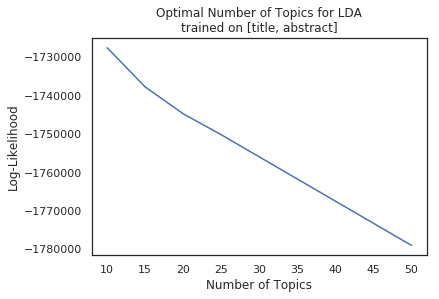

In [50]:
plot_lda_optim_topics(mod, kind='sci', sections=['title', 'abstract'])

In [74]:
%%time
## Run LDA  model using joined bigrams
lda, _, _ = run_lda(dat, tokens=toks, tokenizer=tk, max_df=0.8)


Fitting model...
run_lda finished in 1.88 minutes
CPU times: user 5min 21s, sys: 20.1 s, total: 5min 41s
Wall time: 1min 52s


In [76]:
##pickle_save(lda, 'lda_sci_20_title_abstract')
lda

LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=200, max_iter=50,
             mean_change_tol=0.001, n_components=15, n_jobs=4,
             n_topics=None, perp_tol=0.1, random_state=999,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [66]:
# Plotting functions for scikit models
def print_top_words(model, feature_names, n_top_words, **kw):
    """Print top weighted words in model -- see scikit-learn tutorial."""
    title = kw.pop("title", f"Top {n_top_words} for each topic")
    print(title)
    print()
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ' '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

    
def plot_lda_topic_barplot(model, topic, feature_names, n_words, **kw):
    """Plot barplot of weights of top n_words in topic."""
    fig, ax = plt.subplots(1, 1)
    inds = model.components_[topic].argsort()[:-n_words - 1:-1]
    sns.barplot(x=np.array(feature_names)[inds], y=model.components_[topic][inds],
                palette='hls', ax=ax) # palette='Blues_d'
    ax.set_xticks(np.arange(n_words))
    ax.set_xticklabels(np.array(feature_names)[inds], rotation=45)
    fig.subplots_adjust(bottom=0.2)
    ax.yaxis.grid()
    plt.title(f"Topic #{topic}: top {n_words} words")
    plt.show()

# Examine some results of the LDA model

In [77]:
print_top_words(lda, tk.get_feature_names(), 10)

Top 10 for each topic

Topic #0: matrix dimensional sparse high analysis data low high_dimensional high dimensional rank
Topic #1: rate information learning convergence function learn result distribution optimal weight
Topic #2: graph graphical gradient graphical model graphical_model vector machine support structure gradient_descent
Topic #3: image object use visual recognition feature scene detection segmentation convolutional
Topic #4: monte carlo carlo monte_carlo monte chain cortex field correlation markov chain markov_chain
Topic #5: policy learn decision reinforcement game agent value reinforcement_learn reinforcement learn reward
Topic #6: user spectral field channel receptive receptive field receptive_field speech pose sound
Topic #7: algorithm problem method optimization propose function convex solution paper solve
Topic #8: algorithm learn state online regret space time problem action language
Topic #9: network neural neural network neural_network use train time input layer 

Some of the topics are obviously related to certain fields, eg. topics 2 and 3. Although you can see the topic distribution in topic three more skewed. After realizing that the gensim library already implemented collocation and had some other useful models, further scikit LDA exploration was abandoned.

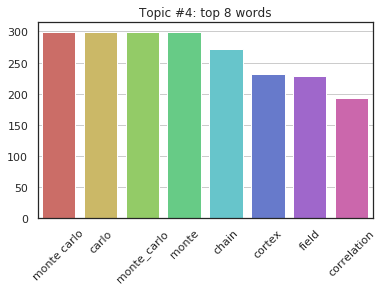

In [81]:
plot_lda_topic_barplot(lda, 4, tk.get_feature_names(), 8)

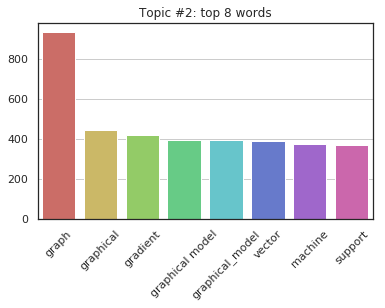

In [80]:
plot_lda_topic_barplot(lda, 2, tk.get_feature_names(), 8)

In [83]:
def print_closest_matches(model, vect, df, num_titles=3, **kw):
    """Print the paper section (default title) of the closest
    matching papers to each topic."""
    section = kw.pop("section", 'title')
    embeddings = model.transform(vect)
    vecs = np.argsort(embeddings, axis=0)[-num_titles:]

    i = 0
    for inds in vecs.T:
        print(f"Topic {i}:")
        for ind in inds:
            print(f"\t ({df.iloc[ind, 1]}){df.iloc[ind][section]:>10}")
        i += 1

In [84]:
# Print the top couple matching title for each topic and its year
print_closest_matches(lda, toks, nips.raw, num_titles=2)

Topic 0:
	 (2003)Locality Preserving Projections
	 (1995)Symplectic Nonlinear Component Analysis
Topic 1:
	 (1991)Estimating Average-Case Learning Curves Using Bayesian, Statistical Physics and VC Dimension Methods
	 (1989)Asymptotic Convergence of Backpropagation: Numerical Experiments
Topic 2:
	 (2002)Fractional Belief Propagation
	 (2003)Tree-structured Approximations by Expectation Propagation
Topic 3:
	 (2008)Grouping Contours Via a Related Image
	 (1991)Linear Operator for Object Recognition
Topic 4:
	 (1988)Theory of Self-Organization of Cortical Maps
	 (1990)Simple Spin Models for the Development of Ocular Dominance Columns and Iso-Orientation Patches
Topic 5:
	 (1999)Low Power Wireless Communication via Reinforcement Learning
	 (1998)Using Collective Intelligence to Route Internet Traffic
Topic 6:
	 (1995)Onset-based Sound Segmentation
	 (1989)Using a Translation-Invariant Neural Network to Diagnose Heart Arrhythmia
Topic 7:
	 (2011)Better Mini-Batch Algorithms via Accelerated

So, there appears to be some spread between the papers matching each topic and the year they were published. Now, to find trends in topics, the weight of each topic was summed for each document from each year. Then, the yearly weightings were normalized to 1 across all topics.

The top topics were chosen by linear regression on these normalized values across years, topics with the highest slope being the top. Since, topics have no real ordering in LDA, it is dependent on the input documents.

In [85]:
def topics_sci_weight_by_year(model, vect, yrs):
    """Get normalized weights of topics / doc / year"""
    trans = model.transform(vect)   # normalized by topic
    df = pd.DataFrame(trans)
    out = df.groupby(yrs).apply(sum)
    out = pd.DataFrame(out.values / out.values.sum(axis=1)[:, np.newaxis],
                       columns=["T" + str(i) for i in range(model.n_components)])
    out['year'] = yrs.value_counts(ascending=True).index
    return out


def rank_topics_by_slope(topics):
    """Rank topics by slopes over years."""
    lm = LinearRegression()
    xs = np.arange(topics.shape[0]).reshape(-1,1)
    slopes = topics.iloc[:,:-1].apply(lambda ys: lm.fit(xs, ys.values).coef_)
    inds = np.argsort(-slopes.values)[0]
    df = topics.iloc[:, :-1]
    df = df.iloc[:, inds]
    df['year'] = topics['year']

    return df, inds


def plot_topics_by_year(topics, n_topics):
    """Plot topics matrix as lineplot over the years.
    Expects a dataframe with a year and topics columns."""
    dat, inds = rank_topics_by_slope(topics)
    dat = dat.iloc[:, :n_topics]
    dat['year'] = topics['year']
    dat = dat.melt(id_vars=['year'], var_name='topic', value_name='weight')
    
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(x='year', y='weight', hue='topic', data=dat)
    plt.title("Top trending topics from NIPs")
    plt.xticks(range(1987, 2018, 5))
    plt.show()
    return inds

In [90]:
wgts = topics_sci_weight_by_year(lda, toks, nips.raw.year)
wgts.head()

T0        T1        T2        T3        T4        T5        T6  \
0  0.019102  0.089921  0.017145  0.025007  0.025320  0.018018  0.007117   
1  0.005868  0.074865  0.017184  0.033923  0.038177  0.013414  0.009042   
2  0.014290  0.058416  0.013593  0.043050  0.036598  0.022413  0.027145   
3  0.019248  0.077595  0.016359  0.054041  0.022570  0.028342  0.012027   
4  0.013775  0.079724  0.010186  0.063320  0.020531  0.020058  0.014771   

         T7        T8        T9       T10       T11       T12       T13  \
0  0.066109  0.016276  0.425176  0.036465  0.016325  0.208964  0.026737   
1  0.049058  0.045132  0.406198  0.043374  0.021694  0.179723  0.048649   
2  0.043505  0.043415  0.367761  0.047480  0.036723  0.145982  0.086223   
3  0.061492  0.036190  0.374695  0.040386  0.022229  0.145602  0.080667   
4  0.051334  0.047199  0.315683  0.050709  0.042809  0.165683  0.091556   

        T14  year  
0  0.002318  1987  
1  0.013699  1988  
2  0.013404  1989  
3  0.008557  1992  
4  0.012663  1994

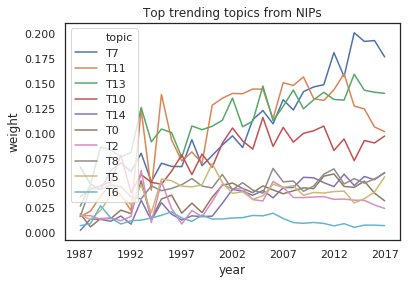

In [91]:
## Rank top 10 trending topics by slope and plot
inds = plot_topics_by_year(wgts, 10)

In [92]:
## Print the top words associated with the top topics
def topics_sci_top_words(model, topics, feature_names, n_top_words):
    """Top n words for model topics."""
    tops = {}
    for t in topics:
        tops["Topic"+str(t)] = [feature_names[i] for i in
                              model.components_[t].argsort()[:-n_top_words:-1]]
    return pd.DataFrame(tops)

topics_sci_top_words(lda, inds, tk.get_feature_names(), 10)

Topic7       Topic11    Topic13         Topic10    Topic14  \
0     algorithm         model      bound           learn     kernel   
1       problem     inference  algorithm            task        art   
2        method          data     sample  classification  state_art   
3  optimization      bayesian    cluster        learning  state art   
4       propose           use       data            data       data   
5      function  distribution        set           label      state   
6        convex       process   function         propose     method   
7      solution      gaussian      error          method    feature   
8         paper      approach     number             use      learn   

             Topic0           Topic2     Topic8               Topic5  \
0            matrix            graph  algorithm               policy   
1       dimensional        graphical      learn                learn   
2            sparse         gradient      state             decision   
3              high  graphical model     online        reinforcement   
4          analysis  graphical_model     regret                 game   
5              data           vector      space                agent   
6               low          machine       time                value   
7  high_dimensional          support    problem  reinforcement_learn   
8  high dimensional        structure     action  reinforcement learn   

            Topic6        Topic3        Topic4        Topic1      Topic12  \
0             user         image   monte carlo          rate        model   
1         spectral        object         carlo   information        human   
2            field           use   monte_carlo      learning          use   
3          channel        visual         monte   convergence  information   
4        receptive   recognition         chain      function     response   
5  receptive field       feature        cortex         learn       signal   
6  receptive_field         scene         field        result         time   
7           speech     detection   correlation  distribution       neuron   
8             pose  segmentation  markov chain       optimal     stimulus   

           Topic9  
0         network  
1          neural  
2  neural network  
3  neural_network  
4             use  
5           train  
6            time  
7           input  
8           layer

So, there is definetly soome coherency to the topics. Some of them are more obvious than others, eg. topic2 appears related to SVM and graphical models while topic 5 is related to reinforcement learning.

# LDA with gensim
1. gensim's LDA allows evaluated with a coherence metric which turned out to be much better
2. There are also options to run multicore, but then a symmetric alpha must be assumed, which tends to perform more poorly, so it was abandoned.
3. The gensim Phrases were used to create collocated bigrams and trigrams, which really helped with interpretability and removing excess common unigrams, improving the model overall.
4. Stemming was tried, but decided against due to little gain and more difficulty with interpretation.
5. Optimizing for the number of topics using the coherence metric resulted in an optimal number b/w 15 and 20 using title+abstract and bigrams and trigrams.

# Gensim LDA defaults

In [95]:
# default LDA params
lda_gensim_defaults = dict(
    num_topics = 18, # determined after optimization
    decay = 0.5,
    passes = 20,
    random_state=RANDOM_SEED,
    alpha='auto',    # symmetric not as good
    eta='auto',
    per_word_topics=True,
    eval_every=None,
    chunksize=4000,
    iterations=400
)

In [96]:
# These classes/functions do text preparation for gensim models
class GensimTokenizer(LemmaTokenizer):
    """
    Remove stopwords and use nltk's word tokenizer instead of regex.
    Optionally, stem words and convert '-' to '_', used when creating ngrams.
    """
    def __init__(self, **kw):
        super().__init__(**kw)
        self.sw = set(stopwords.words('english'))
        self.stem = kw.pop("stem", False)
        self.ps = PorterStemmer()
        self.translate = kw.pop("translate", False)

    def __call__(self, doc):
        res = [self.wnl.lemmatize(w, pos=self.tags[t[0]]) for w,t in
               pos_tag(word_tokenize(doc)) if t[0] in self.tags and len(w) > 2]
        stem = [self.ps.stem(w) for w in res] if self.stem else res
        return list(filter
                    (lambda x: len(x) > 2 and x[0] not in ['-', '_'],
                     [w.replace('-', '_') for w in stem]))\
                     if self.translate else stem



def tokenize_lemmatize(data, keep_joins=False, **kw):
    """Tokenize, lemmatize, and optionally stem. keep_joins keeps [-_].
    Optional args: 
      stem=True: use PorterStemmer to stem words
      translate=True: convert '-' to '_'
    """
    return data.apply(text_preprocess)\
               .apply(GensimTokenizer(translate=keep_joins, **kw))


# Preparation
Prep for the gensim models included:
1. Created Phrases, aka. ngrams (not removing the unigrams so they could be filtered by frequency) using collocated unigrams.
2. Filtering out common / uncommon phrases
3. Building a dictionary / bag of words from the tokens

In [97]:
def _docs_add_ngrams(docs, grams):
    """Add ngrams to docs, keeping orignial unigrams. Otherwise, when reducing
    the words by frequency of occurence, common unigrams can be kept."""
    for idx in range(len(docs)):
        for token in grams[docs[idx]]:
            if '_' in token:
                docs[idx].append(token)
    return docs


def docs_add_ngrams(docs, trigram=False, **kw):
    """Add ngrams to docs. If trigram is True, add both bi/trigrams.
    Optional arguments:
      bg_min_count: passed to bigram Phrases
      bg_threshold: passed to bigram Phrases
    All others are passed to trigram Phrases.
    """
    bg_min_count = kw.pop("bg_min_count", 5)
    bg_threshold = kw.pop("bg_threshold", 100)
    scoring = kw.pop("scoring", 'default')
    ds = list(docs.values)

    bigrams = Phrases(ds, min_count=bg_min_count, threshold=bg_threshold,
                      scoring=scoring)
    ds = _docs_add_ngrams(ds, bigrams)

    if trigram:
        trigrams = Phrases(bigrams[ds], scoring=scoring, **kw)
        ds = _docs_add_ngrams(ds, trigrams)

    return pd.Series(ds, index=docs.index)


def docs_to_dict(docs, **kw):
    """Convert docs to Dictionary and BOW, filtering common/rare words.
    Returns (dictionary, BOW)"""
    no_below = kw.pop("no_below", .02)
    no_above = kw.pop("no_above", 0.9)
    d = Dictionary(docs)
    d.filter_extremes(no_below=no_below, no_above=no_above, **kw)
    d.compactify()
    return d, docs.apply(d.doc2bow)


def lda_get_corpus(data, **kw):
    """
    Generate corpus from raw data. This involves all of the preprocessing
    steps.

    Optional args:
      - name: save filename
      - save: True if should save corpus (if no name, uses 'temp_corpus')
    """
    keep_joins = kw.pop("keep_joins", False)
    use_trigrams = kw.pop("use_trigrams", True)
    name = kw.pop("name", None)
    save = kw.pop("save", False)
    savepath, exists = get_save_path(name if name else "temp_corpus") if save\
        else (None, False)

    if name and exists:
        return pickle_load(savepath)
        
    print("Tokenizing...")
    docs = tokenize_lemmatize(data, keep_joins=keep_joins)
    print("Adding N-grams...")
    docs = docs_add_ngrams(docs, trigram=use_trigrams)
    if save and name:
        docs.to_pickle(savepath)

    return docs


def lda_get_dictionary(data, **kw):
    """Create gensim BOW/Dictionary from raw data using defaults."""
    no_below = kw.pop("no_below", 0.02)
    no_above = kw.pop("no_above", 0.6)
    name = kw.get('name', None)  # prefix for saves, passs on
    save = kw.get('save', False)
    savepath = get_save_path(name)[0] if name else None
    
    if name and os.path.exists(savepath + "_bow"):
        bow = pickle_load(savepath + "_bow")
        d = corpora.Dictionary.load(savepath + "_dict")
    else:
        docs = lda_get_corpus(data, **kw)
        d, bow = docs_to_dict(docs, no_below=no_below, no_above=no_above)

        if save:                    # save dictionary, and BOW
            d.save(savepath + "_dict")
            bow.to_pickle(savepath + "_bow")

    return d, bow

# Running gensim LDA models
Again these were tried on different combinations of the dataset and pickled since running on the whole corpus can take quite some time.
The sections chosen were title+abstract as before using both bigrams and trigrams creating using statistically collocated terms, as implemented by Phrases.

Using low values for removing frequent terms tended to lead to better results after joining phrases, unsurprisingly since the unigrams would be most frequent.

In [98]:
## -------------------------------------------------------------------
### Loading and running Models / Data

def lda_load_model(fname):
    """Try to load a model if already trained."""
    pklpath, exists = get_save_path(fname)
    return LdaModel.load(pklpath) if exists else None

    
@timeit
def run_lda_gensim(data, **kw):
    """
    Constructs gensim BOW from data, adding bigrams and trigrams by default.
    Uses lda_gensim_defualts, but they are overriden by passed params.
    """
    d, bow = lda_get_dictionary(data, **kw)
    lda_args = {**lda_gensim_defaults, **kw}
    lda_args.pop('name', None)
    lda_args.pop('save', None)
    return LdaModel(corpus=bow, id2word=d, **lda_args)
    

@timeit
def run_lda_gensim_all_models(nips, params=lda_gensim_defaults,
                              sections=[["title", "abstract"]], **kw):
    """Run LDA on sections of NIPs dataset."""
    for section in sections:
        dat = nips.raw[section] if isinstance(section, str) else \
            nips.raw[section].apply(lambda x: '\n'.join(x), axis=1)
        name = get_save_name(section)
        ntopics = kw.get('num_topics', params['num_topics'])
        modname = f"lda_{ntopics}_" + name

        mod = lda_load_model(modname)
        if mod:
            print(f"Loaded saved LDA model: {modname}")
        else:
            print(f"Running LDA on {section}...")
            mod = run_lda_gensim(dat, name=name, save=True, num_topics=ntopics)
            path, have = get_save_path(modname)
            mod.save(path)

# Optimizing Gensim LDA number of components
- scoring function used was the coherence score
- the gensim model was wrapped to allow it to be evaluated by scikits cross-validation
- models were optimized using title+abstract and title+abstract+text.

In [99]:
def get_nips_combined(sections, data=None):
    """Return combined NIPs sections."""
    nips = NipsData()
    nips.load_data()
    return nips.combined_sections(sections, data)


def lda_gensim_to_sci(data, sections, n_topics, **kw):
    """Wrap gensim LDA model for scikit-learn."""
    dat = get_nips_combined(sections, data)
    d, bow = lda_get_dictionary(d, **kw)
    
    args = {**lda_gensim_defaults, **kw}
    args.pop('per_word_topics')
    args['num_topics'] = n_topics
    return LdaTransformer(id2word=d, **args)


def lda_coherence(model, corpus, dic):
    """Compute the coherence score."""
    cm = CoherenceModel(model=model, texts=corpus, dictionary=dic, coherence='c_v')
    return cm.get_coherence()

Due to the wrapping function, a global reference to the corpus needed to be maintained, the parameter "texts" below.

In [100]:
# example run using two sections
sections = ['title', 'abstract']
dat = nips.combined_sections(sections, data=nips.raw)
sname = get_save_name(sections)
# used by lda_gensim_score
docs = lda_get_corpus(dat, save=True, name=sname)
d, bow = lda_get_dictionary(dat, save=True, name=sname)

def lda_gensim_score(estimator, X, y=None):
    """To pass to grid search. Note: docs must be defined globally, this
    should be wrapped in optimize, but can't pickle in that case."""
    cm = CoherenceModel(model=estimator.gensim_model, texts=docs,
                        dictionary=estimator.gensim_model.id2word,
                        coherence='c_v')
    return cm.get_coherence()

@timeit
def lda_gensim_optimize(data, pgrid={'num_topics': [10, 15, 20, 30]},
                        **kwn):
    """Optimize number of topics using coherence score."""
    d, bow = lda_get_dictionary(data)

    obj = LdaTransformer(id2word=d, num_topics=10, iterations=50, passes=8,
                         alpha='symmetric', chunksize=4000)
    mod = GridSearchCV(obj, param_grid=pgrid, scoring=lda_gensim_score)
    mod.fit(bow)

    return mod

In [101]:
optims = pickle_load('lda_gensim_optim.pkl')
ta, tat = optims.get('lda_gensim_title_abstract'),\
    optims.get('lda_gensim_title_abstract_text')

# examine results
print_lda_optim_results(ta, data=bow)

LDA optimized using grid search
The scoring function used here is Coherence
--------------------
GridSearchCV(cv=None, error_score='raise',
       estimator=LdaTransformer(alpha='symmetric', chunksize=4000, decay=0.5,
        dtype=<class 'numpy.float32'>, eta=None, eval_every=10,
        gamma_threshold=0.001,
        id2word=<gensim.corpora.dictionary.Dictionary object at 0x7fa3c9595940>,
        iterations=50, minimum_probability=0.01, num_topics=10, offset=1.0,
        passes=8, random_state=None, scorer='perplexity', update_every=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'num_topics': [10, 12, 14, 15, 16, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function lda_gensim_score at 0x7fa3c2138268>, verbose=0)

Best LDA model
--------------------

  - Params:          {'num_topics': 20}
  - Coherence:       0.387880542668375
  - Perplexity:      -204.1579546208415

Best Model:
LdaTransformer(alpha='symmetric',

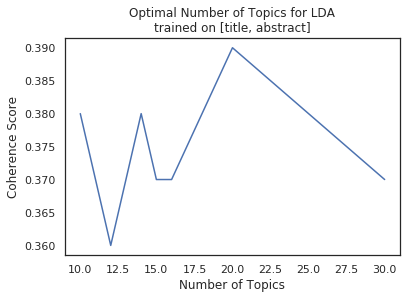

In [110]:
plot_lda_optim_topics(ta, sections=sections)

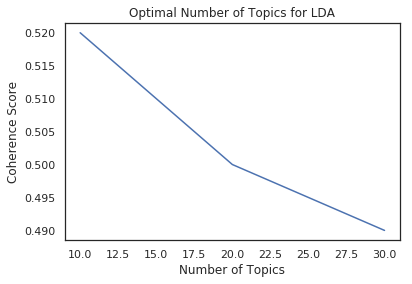

In [111]:
plot_lda_optim_topics(tat)

The model with only the title and abstract peaked at 20 topics, while the model with all sections showed a similar trend as before, increasing as the topics decreased.

Since the sections used were title and abstract, a happy medium of ~15 topics was chosen as the default.

In [102]:
# Load / Run models
lda1 = lda_load_model('lda_18_title_abstract');
if lda1 is None:
    lda1 = run_lda_gensim(dat, name='title_abstract', num_topics=18)

In [103]:
lda2 = lda_load_model('lda_20_title_abstract')
if lda2 is None:
    lda2 = run_lda_gensim(dat, name='title_abstract', num_topics=20)

In [104]:
%%time
lda3 = lda_load_model('lda_30_title_abstract')
if lda3 is None:
    lda3 = run_lda_gensim(dat, name='title_abstract', num_topics=30)

CPU times: user 17.8 ms, sys: 3.87 ms, total: 21.6 ms
Wall time: 20.7 ms


In [105]:
def print_lda_model_summary(model, corpus, bow, d, **kw):
    """Print summary of model performance."""
    hdr = kw.pop('hdr', None)
    c_v = kw.pop('c_v', False)
    if hdr is not None:
        print(hdr)
        print("--------------------")
    print(f"Topics: {model.num_topics}")
    print(f"Passes: {model.passes}")
    print(f"Perplexity: {model.log_perplexity(bow)}")
    if c_v:
        print(f"Coherence: {lda_coherence(model, docs, d):0.3f}")


# Model stats
print_lda_model_summary(lda1, docs, bow, d, hdr="Model 1: title/abstract", c_v=True)
print_lda_model_summary(lda2, docs, bow, d, hdr="Model 2: title/abstract", c_v=True)
print_lda_model_summary(lda3, docs, bow, d, hdr="Model 3: title/abstract", c_v=True)

Model 1: title/abstract
--------------------
Topics: 18
Passes: 10
Perplexity: -7.631426089147335
Coherence: 0.400
Model 2: title/abstract
--------------------
Topics: 20
Passes: 30
Perplexity: -7.596142045836996
Coherence: 0.411
Model 3: title/abstract
--------------------
Topics: 30
Passes: 30
Perplexity: -7.5801745161764655
Coherence: 0.405


In [300]:
def print_lda_topic_coherence(model, corpus, num_words=10):
    """Print average topic coherence: sum of topic coherence / number of topics."""
    top_topics = model.top_topics(corpus, num_words)
    avg = sum([t[1] for t in top_topics]) / model.num_topics
    print(f"Average topic coherence: {avg:0.4f}")
#     pp.pprint(top_topics)

print("lda1: ", end='')
print_lda_topic_coherence(lda1, bow)
print("lda2: ", end='')
print_lda_topic_coherence(lda2, bow)
print("lda3: ", end='')
print_lda_topic_coherence(lda3, bow)

lda1: Average topic coherence: -1.9794
lda2: Average topic coherence: -2.5330
lda3: Average topic coherence: -3.0621


I'm not convinced by the cross-validating results given these coherences increase as more topics are added. There were some differences in the settings however. For these models, more passes and iterations were used, which likely favors models with more topics.

# LDA results
- normalized average topic representation / year
- normalized number of documents where topic had the highest probability / year

In [117]:
# Functions to determine topic contributions by year
def topic_doc_weights_by_year(model, bow, yrs):
    """
    Determine weight of each topic for each year. This the sum of a
    topics contribution to all documents in the year. Yearly topic distributions 
    are normalized to sum to 1.
    """
    doc_dist = model.get_document_topics(bow) # topic contributions to each document
    idx = yrs - min(yrs)
    mat = np.zeros((len(np.unique(yrs)), model.num_topics))
    
    # compute topics contribution to all documents in year
    for i, dist in enumerate(doc_dist):
        for topic, perc in dist:
            mat[idx[i], topic] += perc

    # normalize yearly topic sums
    res = pd.DataFrame(
        mat / mat.sum(axis=1)[:, np.newaxis],
        columns=[f'Topic {i}' for i in range(model.num_topics)])
    res['year'] = yrs.value_counts(ascending=True).index
    return res


def topic_documents_by_year(model, bow, yrs, perc=False):
    """
    Determine the percentage of documents each year where a topic
    was the main contributor. Results are ordered by topic coherence score
    given the text passed.

    If perc=True, then the weight given the topic corresponds to its
    actual probability distribution in the document. Otherwise,
    A dominant topic is assumed to own the whole document.
    """
    doc_dist = model.get_document_topics(bow) # topic contributions to each document
    idx = yrs - min(yrs)
    mat = np.zeros((len(np.unique(yrs)), model.num_topics))
    
    # number of documents where topic is the main contributor
    for i, dist in enumerate(doc_dist):
        mat[idx[i], dist[0]] += dist[0][1] if perc else 1

    # normalize yearly topic sums
    res = pd.DataFrame(
        mat / mat.sum(axis=1)[:, np.newaxis],
        columns=[f'Topic {i}' for i in range(model.num_topics)])

    res['year'] = yrs.value_counts(ascending=True).index
    return res    

In [119]:
# Get results for topics / years
yrs = nips.raw.year
wgts = topic_doc_weights_by_year(lda2, bow, yrs)

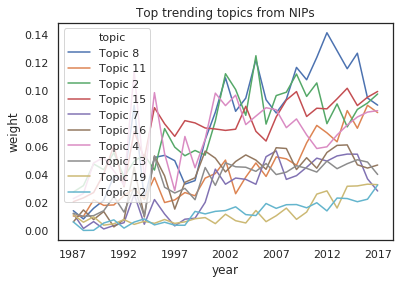

In [120]:
# Plot top topics
## Rank top 10 trending topics by slope and plot
inds = plot_topics_by_year(wgts, 10)

In [125]:
def print_gensim_top_topics(model, topics):
    """Print the top words for each topic and their weights"""
    for t in topics:
        pp.pprint(model.show_topic(t))

print_gensim_top_topics(lda2, inds)

[   ('high_dimensional', 0.019216053),
    ('matrix', 0.018286401),
    ('data', 0.014217463),
    ('method', 0.0133904405),
    ('kernel', 0.01231501),
    ('dimensional', 0.011588485),
    ('sparse', 0.00984053),
    ('high', 0.00917063),
    ('problem', 0.008247209),
    ('analysis', 0.008106935)]
[   ('bound', 0.033142433),
    ('algorithm', 0.018058456),
    ('loss', 0.012776528),
    ('upper_bound', 0.011539257),
    ('complexity', 0.01115231),
    ('show', 0.010070723),
    ('learn', 0.009617688),
    ('bad_case', 0.009416298),
    ('low', 0.009019019),
    ('regret', 0.008957658)]
[   ('learn', 0.023723828),
    ('data', 0.017090054),
    ('state_art', 0.015523549),
    ('label', 0.014193517),
    ('feature', 0.012301297),
    ('model', 0.012206999),
    ('learning', 0.011912062),
    ('object', 0.01110622),
    ('approach', 0.010416891),
    ('image', 0.009944422)]
[   ('function', 0.013088603),
    ('algorithm', 0.011784474),
    ('problem', 0.011339275),
    ('method', 0.010

The top trending topics found using gensim's LDA are similar to those using scikit. Things like collaboritive filtering, bayesian learning, MCMC method, and neural net related topics are on the rise. As noted earlier however, the neural net topic experience a dramatic decline and resurgence.

# LDA-SEQ / DTM
These are topic models that incorporate time as an additional variable.
Gensim has a python version of ldaseq, but it is extremely slow. Trying to run the model took a day and then failed to save. Using the gensim wrapper for the DTM binary worked much better.

However, there wasn't really time to do much analysis on these models sadly, since they would probably be the most informative.

In [126]:
# time_slice: list of ints, eg. counts / year
# take a loooong time
lda_seq_defaults = dict(
    num_topics = 15,
    passes = 5,
    random_state = RANDOM_SEED,
    initialize = 'gensim',      # initialize with gensim model unless have one
    chunksize = 4000,
    em_max_iter = 5
)

In [134]:
# helper functions
def papers_per_year(data):
    """Counts of papers published / year."""
    cnts = data.year.value_counts()
    return list(cnts.index), list(cnts.values)


# takes forever, hours / day
@timeit
def run_ldaseq(data, sections, **kw):
    """Run LDA sequential model."""
    nips = NipsData()
    nips.load_data()
    yrs, cnts = papers_per_year(data)
    data = nips.combined_sections(sections, data)
    name = get_save_name(sections)
    ncomps = kw.get('n_components', lda_seq_defaults['n_components'])
    modname = f"ldaseq_{ncomps}_" + name

    mod = lda_load_model(modname)
    if mod:
        return mod

    d, bow = lda_get_dictionary(data, name=name, save=True)

    print(f"Running LDAseq on {sections}")
    lda_args = {**lda_seq_defaults, **kw}
    mod = LdaSeqModel(corpus=bow, time_slice=cnts, id2word=d, **lda_args)

    path, _ = get_save_path(modname)
    mod.save(path)
    return mod

# DTM wrapper
The DTM wrapper is a gensim wrapper around the dtm binary written in C, which needs to be installed and compiled separately. On linux this was easy, and I think there are binaries availble for other platforms.

In [135]:
# Configurations
dtm_path=os.path.join(root_path(), "../dtm/dtm/main")
dtm_defaults = dict(
    rng_seed=RANDOM_SEED,
    num_topics=15
)

In [136]:
# Takes a long time, but much faster than the python version
@timeit
def dtm_run(data, times, dtm_path, **kw):
    """Run DTM model."""
    sname = kw.pop("name", '_temp_')
    save = kw.pop('save', True)
    d, bow = lda_get_dictionary(data, save=save, name=sname)

    key = f"lda_dtm_{ncomps}_" + sname
    if os.path.exists(os.path.join(PKLDIR, key)):
        return pickle_load(key)
    else:
        mod = DtmModel(dtm_path=dtm_path, corpus=bow, id2word=d,
                    time_slices=times, **dtm_defaults)
        mod.save(os.path.join(PKLDIR, key))
        return mod

In [139]:
# Running the DTM model
dat = nips.load_data(sample_frac=1)
sections = ['title', 'abstract']
sname = get_save_name(sections)
docs = lda_get_corpus(dat, name=sname, save=True)
d, bow = lda_get_dictionary(dat, name=sname, save=True)

dat = nips.combined_sections(sections, data=dat)
yrs, cnts = papers_per_year(nips.raw)

# mod = dtm_run(dat, cnts, dtm_path)
mod = DtmModel.load(os.path.join(PKLDIR, 'lda_dtm_15_title_abstract'))
mod

In [141]:
## Examine a few of the results
def print_dtm_top_words_for_year(model, years, n_topics, n_words):
    """Print top n_words from top n_topics for year in years."""
    print(f"Top {n_words} from top {n_topics} for year(s) {years}:")
    yrs = enumerate(range(1987, 2018))
    inds = [(i,yr) for i, yr in yrs if yr in years]
    
    for i, yr in inds:
        print(f"Year {yr}:")
        for topic, words in enumerate(model.dtm_coherence(i, n_words)[:n_topics]):
            print(f"  Topic #{topic}: " + ', '.join(words))

def dtm_coherence(model, corpus, d, year):
    """Get coherence for DTM model at year."""
    years = enumerate(range(1987, 2018))
    ind = [i for i,yr in years if yr == year][0]
    tw = model.dtm_coherence(time = ind)

    cm = CoherenceModel(topics=tw, texts=corpus, dictionary=d, coherence='c_v')
    return cm.get_coherence()

def print_dtm_coherence_by_year(model, corpus, d):
    """Print Coherence scores for each year in DTM model."""
    years = enumerate(range(1987, 2018))

    print("Coherence scores for each year:")
    for i, yr in years:
        coh = dtm_coherence(model, corpus, d, yr)
        print(f"{yr}: {coh:0.4f}")

In [144]:
print_dtm_coherence_by_year(mod, docs, d)

Coherence scores for each year:
1987: 0.4417
1988: 0.4460
1989: 0.4457
1990: 0.4466
1991: 0.4471
1992: 0.4464
1993: 0.4423
1994: 0.4379
1995: 0.4364
1996: 0.4352
1997: 0.4334
1998: 0.4337
1999: 0.4322
2000: 0.4301
2001: 0.4279
2002: 0.4319
2003: 0.4308
2004: 0.4287
2005: 0.4297
2006: 0.4328
2007: 0.4329
2008: 0.4329
2009: 0.4332
2010: 0.4321
2011: 0.4344
2012: 0.4322
2013: 0.4364
2014: 0.4283
2015: 0.4264
2016: 0.4232
2017: 0.4227


In [145]:
print_dtm_top_words_for_year(mod, [1987, 2000, 2017], 10, 5)

Top 5 from top 10 for year(s) [1987, 2000, 2017]:
Year 1987:
  Topic #0: neuron, model, network, analog, have
  Topic #1: image, object, recognition, use, feature
  Topic #2: algorithm, cluster, problem, distance, graph
  Topic #3: function, use, weight, learn, radial_basis
  Topic #4: bound, algorithm, case, complexity, special_case
  Topic #5: classification, data, classifier, algorithm, use
  Topic #6: speech, speech_recognition, recognition, system, model
  Topic #7: information, mutual_information, cross_validation, data, query
  Topic #8: model, maximum_likelihood, algorithm, probability, likelihood
  Topic #9: network, neural, neural_network, learn, use
Year 2000:
  Topic #0: spike, neuron, neural, model, memory
  Topic #1: image, object, model, state_art, feature
  Topic #2: cluster, graph, algorithm, problem, clustering
  Topic #3: gaussian, process, function, gaussian_process, covariance
  Topic #4: bound, algorithm, online, case, show
  Topic #5: learn, state_art, data, algo

# DTM topics over time
The same technique was used here as previosly with the LDA models. Topic weights normalized across all documents for each year.

In [150]:
def dtm_topics_by_year(model, corpus, yrs):
    """Calculate the normalized weights of topics over time and the most
    relevant words."""
    topics = model.num_topics
    num_yrs = len(yrs.unique())
    mat = np.zeros((num_yrs, model.num_topics))
    words = pd.DataFrame()
    
    for yr in range(num_yrs):
        for t in range(topics):
            dist = model.show_topic(t, yr)
            ws = []
            for val, word in model.show_topic(t, yr):
                mat[yr, t] += val
                ws.append(word)
            words[f'Topic {t}'] = ws

    res = pd.DataFrame(mat / mat.sum(axis=1)[:, np.newaxis],
                       columns=[f'Topic {i}' for i in range(model.num_topics)])
    res['year'] = yrs.value_counts(ascending=True).index
    return res, words

dist, words = dtm_topics_by_year(mod, bow, nips.raw.year)
dist.head()

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
0  0.050708  0.058160  0.063565  0.061914  0.070549  0.067977  0.087154   
1  0.050613  0.058149  0.064207  0.062232  0.070812  0.067880  0.086230   
2  0.050833  0.058367  0.065339  0.063160  0.071064  0.067729  0.084840   
3  0.051476  0.058722  0.066940  0.064570  0.071147  0.067602  0.083203   
4  0.052500  0.059231  0.068753  0.066397  0.071069  0.067505  0.081542   

    Topic 7   Topic 8   Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  \
0  0.065994  0.066920  0.069162  0.069168  0.075383  0.074255  0.045848   
1  0.066092  0.067043  0.068905  0.069022  0.075445  0.073901  0.045843   
2  0.066020  0.067069  0.068614  0.068617  0.075202  0.073219  0.045994   
3  0.065788  0.067056  0.068415  0.068052  0.074622  0.072106  0.046286   
4  0.065399  0.067011  0.068400  0.067432  0.073893  0.070143  0.046829   

   Topic 14  year  
0  0.073243  1987  
1  0.073625  1988  
2  0.073933  1989  
3  0.074017  1992  
4  0.073895  1994

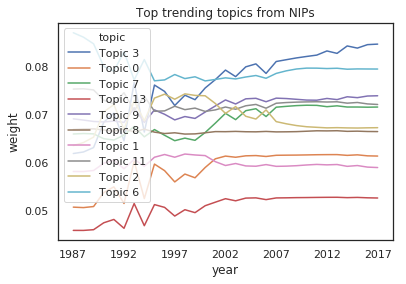

In [151]:
# Plotting top DTM topics over time
inds = plot_topics_by_year(dist, 10)

And the corresponding top words for the top 10 trending topics using DTM were:

In [155]:
words.iloc[:, inds].head(10)

Topic 3  Topic 0       Topic 7    Topic 13         Topic 9  \
0            kernel   memory   information       model         network   
1          gaussian    spike          data      neural          neural   
2           process   neural         model       brain            deep   
3          function   neuron         query       human           model   
4  gaussian_process   system         learn      visual  neural_network   
5        covariance    model  ground_truth  population           train   
6     approximation  network          time   attention           learn   
7        regression  dynamic         label    response    architecture   
8               use     time           use         use           layer   
9            method  circuit        active    activity        learning   

              Topic 8         Topic 1      Topic 11     Topic 2  \
0               model           image         model     cluster   
1           inference       state_art          data   algorithm   
2         variational           model        latent       graph   
3            variable  representation      bayesian  clustering   
4           algorithm          object       process     problem   
5  maximum_likelihood           learn  distribution         use   
6        distribution             use     inference        node   
7          likelihood         propose        sample        data   
8                 use             art  markov_chain        have   
9  exponential_family            task     posterior  similarity   

                  Topic 6       Topic 10          Topic 14    Topic 4  \
0  generative_adversarial         policy  high_dimensional      bound   
1                   learn       function       dimensional  algorithm   
2             adversarial      algorithm              data     regret   
3                   agent          learn              high    problem   
4                    game  reinforcement         estimator     online   
5                  domain        problem        estimation     sample   
6              generative       decision             space     result   
7                   model   optimization            method   function   
8                    task         reward          analysis    optimal   
9       domain_adaptation          value            sample       case   

          Topic 5          Topic 12  
0            data         algorithm  
1       state_art          gradient  
2           learn  gradient_descent  
3         propose           problem  
4      real_world            method  
5          method      optimization  
6         feature            matrix  
7        datasets       convergence  
8        learning            convex  
9  semi_supervise        stochastic